## Cluster methods

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sns.set_theme(
    style="whitegrid",
    font_scale=1,
    rc={
        "figure.dpi": 150,
        "savefig.dpi": 300
    }
)
tol_colors = [ "#0072B2", "#E69F00", "#009E73", "#F0E442", "#D55E00", "#CC79A7", "#999999",  "#56B4E9"]
sns.set_palette(tol_colors)

plt.rcParams.update({
    "font.size": 12,          # default font size for all text
    "axes.titlesize": 12,     # subplot titles
    "axes.labelsize": 12,     # x and y labels
    "xtick.labelsize": 12,    # tick labels
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "figure.titlesize": 14,    # fig.suptitle()
    "xtick.bottom": True,   # show ticks on x-axis bottom
    "xtick.top": False,     # hide ticks on x-axis top
    "ytick.left": True,     # show ticks on y-axis left
    "ytick.right": False,   # hide ticks on y-axis right
    "xtick.direction": "out",
    "ytick.direction": "out"
})

results_df = pd.read_csv("results/big_dataset/targeted/cam_comparison_metrics_combined.csv")
metric_columns = [
    'mean pixel difference', 'percentage of different pixels',
    'cosine similarity', 'activation ratio', 'JS divergence',
    'important activation ratio', 'intersection over union', 'SSIM',
    'Spearman\'s rank coefficient', 'number of regions difference']

selected_metrics = ["percentage of different pixels", "cosine similarity", "activation ratio", "important activation ratio", "number of regions difference", "intersection over union"]

In [5]:
results_df["percentage of different pixels"] = results_df["percentage of different pixels"] / 100.0    # Normalize percentage of different pixels

single_attack_df = results_df[results_df["attack"] == "Fast Gradient Sign Method (FGSM)"]

In [6]:
print("Creating method profiles...")
method_profiles = results_df.groupby('method')[metric_columns].mean()

# Create richer profiles using multiple aggregations
method_profiles = results_df.groupby('method')[metric_columns].agg(['mean', 'std', 'median'])

# This creates multi-level columns (e.g., 'cosine similarity_mean', 'cosine similarity_std')
# We can flatten them for easier use with scikit-learn
method_profiles.columns = ['_'.join(col).strip() for col in method_profiles.columns.values]

print(f"Number of unique methods: {len(method_profiles)}")
print(f"Method profiles shape: {method_profiles.shape}")

Creating method profiles...
Number of unique methods: 9
Method profiles shape: (9, 30)


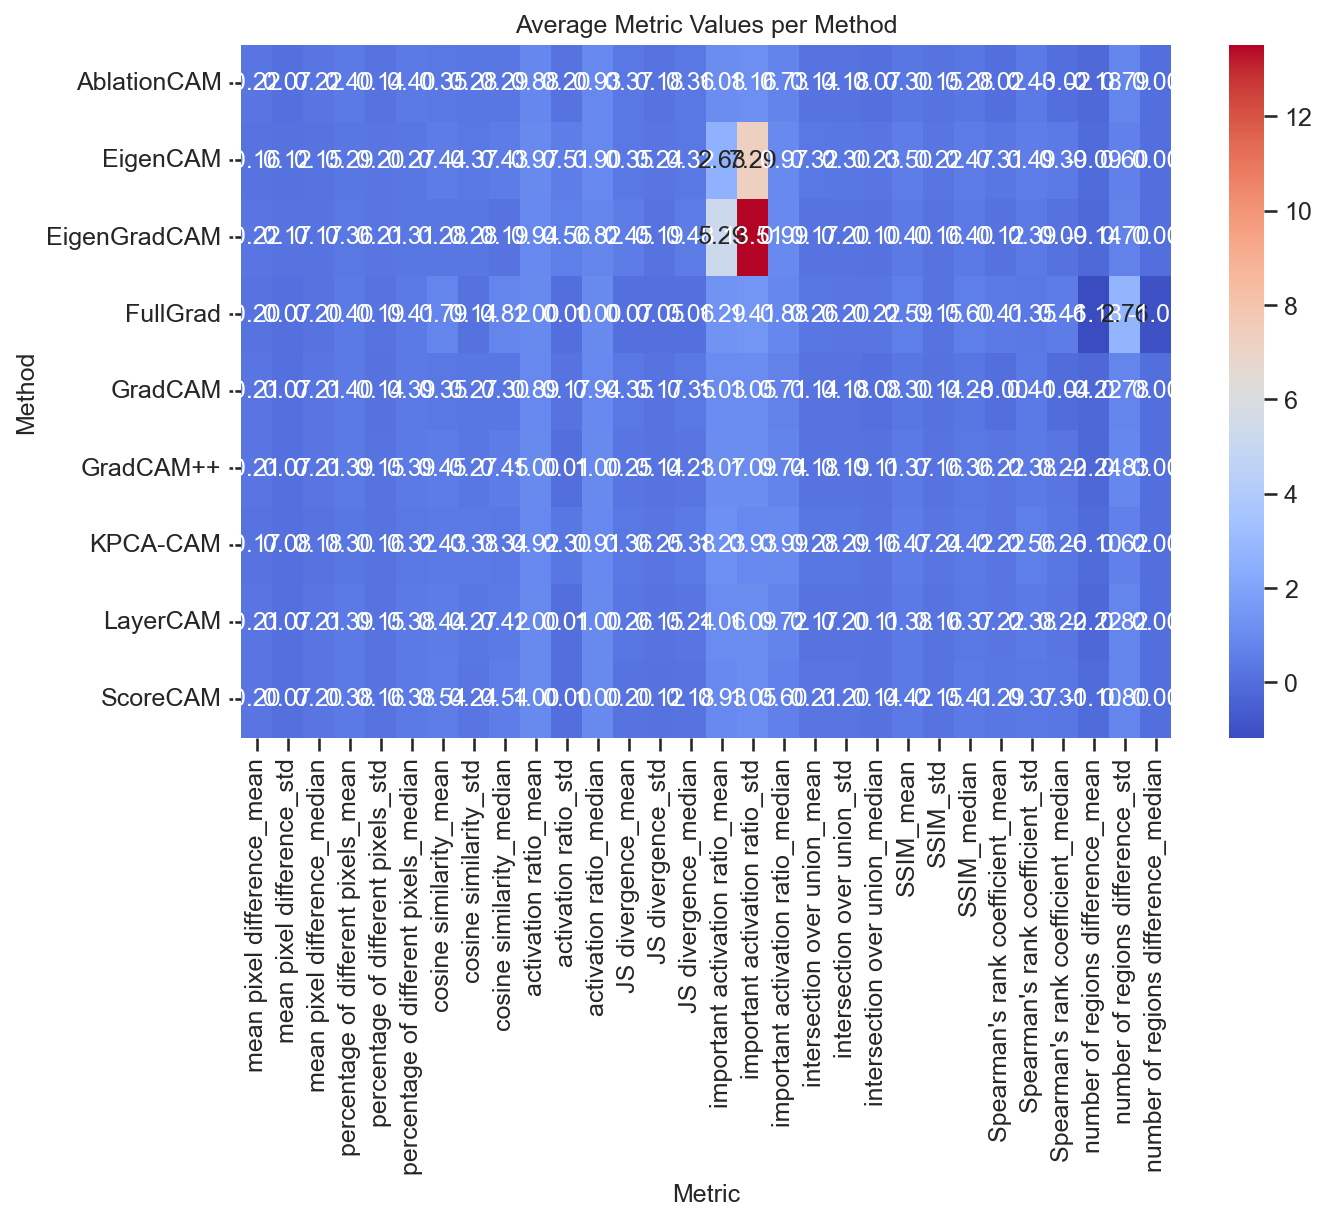

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(method_profiles, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Average Metric Values per Method")
plt.ylabel("Method")
plt.xlabel("Metric")
plt.show()

In [7]:
# Step 2: Standardize the data for clustering
print("\nStandardizing the data...")
scaler = StandardScaler()
method_profiles_scaled = scaler.fit_transform(method_profiles)
method_profiles_scaled_df = pd.DataFrame(method_profiles_scaled, 
                                        index=method_profiles.index, 
                                        columns=method_profiles.columns)
method_profiles_scaled_df


Standardizing the data...


mean pixel difference_mean  mean pixel difference_std  \
method                                                                
AblationCAM                     0.860455                  -0.533980   
EigenCAM                       -1.893099                   0.858645   
EigenGradCAM                    1.100324                   2.540637   
FullGrad                       -0.048662                  -0.515641   
GradCAM                         0.712080                  -0.612509   
GradCAM++                       0.393071                  -0.574196   
KPCA-CAM                       -1.630517                  -0.135087   
LayerCAM                        0.337933                  -0.566367   
ScoreCAM                        0.168415                  -0.461501   

              mean pixel difference_median  \
method                                       
AblationCAM                       1.066658   
EigenCAM                         -2.095472   
EigenGradCAM                     -1.128593   
FullGrad                          0.155420   
GradCAM                           0.927560   
GradCAM++                         0.675011   
KPCA-CAM                         -0.585166   
LayerCAM                          0.615237   
ScoreCAM                          0.369346   

              percentage of different pixels_mean  \
method                                              
AblationCAM                              0.857610   
EigenCAM                                -1.872965   
EigenGradCAM                            -0.199314   
FullGrad                                 0.906917   
GradCAM                                  0.695894   
GradCAM++                                0.544048   
KPCA-CAM                                -1.680095   
LayerCAM                                 0.450195   
ScoreCAM                                 0.297710   

              percentage of different pixels_std  \
method                                             
AblationCAM                            -0.909905   
EigenCAM                                1.543184   
EigenGradCAM                            1.593357   
FullGrad                                0.968599   
GradCAM                                -0.985351   
GradCAM++                              -0.668822   
KPCA-CAM                               -0.450954   
LayerCAM                               -0.766324   
ScoreCAM                               -0.323786   

              percentage of different pixels_median  cosine similarity_mean  \
method                                                                        
AblationCAM                                0.854970               -0.768716   
EigenCAM                                  -2.022468               -0.062490   
EigenGradCAM                              -1.146405               -1.235627   
FullGrad                                   1.053864                2.433461   
GradCAM                                    0.667242               -0.734396   
GradCAM++                                  0.566531                0.022048   
KPCA-CAM                                  -0.796655               -0.189346   
LayerCAM                                   0.496159               -0.077315   
ScoreCAM                                   0.326762                0.612380   

              cosine similarity_std  cosine similarity_median  \
method                                                          
AblationCAM               -0.005909                 -0.749851   
EigenCAM                   1.414535                  0.082548   
EigenGradCAM              -0.008398                 -1.365407   
FullGrad                  -2.091155                  2.312014   
GradCAM                   -0.107205                 -0.695576   
GradCAM++                 -0.128628                  0.149223   
KPCA-CAM                   1.524866                 -0.455629   
LayerCAM                  -0.082333                  0.010384   
ScoreCAM                  -0.515774             

<Axes: >

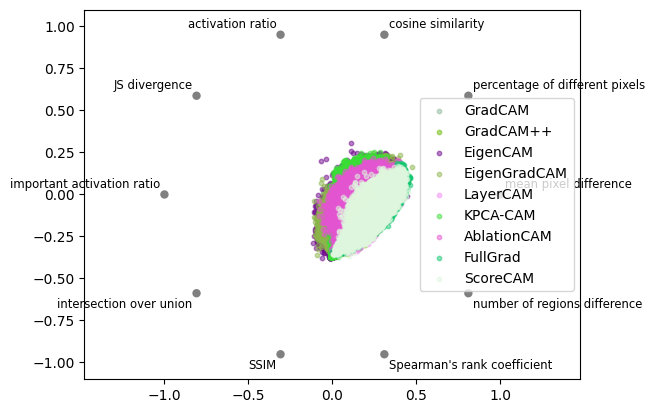

In [8]:
# visualize radviz with reduced point size
pd.plotting.radviz(results_df[metric_columns + ['method']], 'method', alpha=0.5, s=10)

In [9]:
reduced_data = results_df.sample(10000, random_state=33)

In [10]:
results_df.columns

Index(['image ID', 'method', 'attack', 'true class', 'predicted class',
       'images mean difference', 'original score', 'adversarial score',
       'mean pixel difference', 'percentage of different pixels',
       'number of regions original', 'number of regions adversarial',
       'cosine similarity', 'activation ratio', 'JS divergence',
       'important activation ratio', 'intersection over union', 'SSIM',
       'Spearman's rank coefficient', 'number of regions difference'],
      dtype='object')

In [11]:
## add method as categorical float to dataframe
results_df['method_float'] = results_df['method'].astype('category').cat.codes.astype(float)

In [12]:
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

methods = results_df['method'].unique()
attacks = results_df['attack'].unique()
# check distance correlation for each method, attack
for method in methods:
    for attack in attacks:
        subset = results_df[(results_df['method'] == method) & (results_df['attack'] == attack)]
        if not subset.empty and len(subset) > 5:  # Need enough samples for meaningful correlation
            # Calculate distance correlation for each metric
            images_mean_diff = subset['images mean difference'].values
            
            for metric in metric_columns:
                metric_values = subset[metric].values
                
                # Calculate Pearson correlation as a simple distance measure
                if len(np.unique(images_mean_diff)) > 1 and len(np.unique(metric_values)) > 1:
                    corr_coef, p_value = pearsonr(images_mean_diff, metric_values)
                    
                    # Print if correlation is significant (|r| > 0.5 and p < 0.05)
                    if abs(corr_coef) > 0.5 and p_value < 0.05:
                        print(f"Method: {method}, Attack: {attack}")
                        print(f"  {metric}: r={corr_coef:.3f}, p={p_value:.3f}")

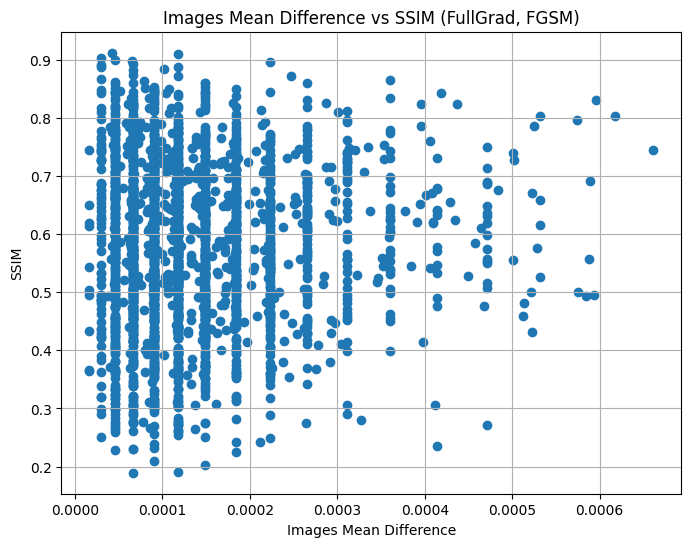

In [13]:
# plot images mean difference against SSIM for attack Fast Gradient Sign Method (FGSM) and method FullGrad

plt.figure(figsize=(8, 6))

selected_data = results_df[(results_df['method'] == 'FullGrad') & (results_df['attack'] == 'L2 FMN')]

plt.scatter(selected_data['images mean difference'], selected_data['SSIM'])
plt.xlabel('Images Mean Difference')
plt.ylabel('SSIM')
plt.title('Images Mean Difference vs SSIM (FullGrad, FGSM)')
plt.grid()
plt.show()

In [14]:
pivoted = results_df.pivot_table(
    index=['image ID', 'method'],
    columns='attack',
    values=metric_columns
)
pivoted

JS divergence                                            \
attack                   DDN Attack    L1 FMN L2 Basic Iterative Method (BIM)   
image ID method                                                                 
0        AblationCAM       0.639790  0.652738                        0.622892   
         EigenCAM          0.664802  0.230685                        0.155462   
         EigenGradCAM      0.676801  0.250491                        0.239085   
         FullGrad          0.124528  0.102871                        0.125535   
         GradCAM           0.601049  0.614408                        0.552754   
...                             ...       ...                             ...   
2999     GradCAM           0.297782  0.520300                        0.369360   
         GradCAM++         0.154643  0.347840                        0.243323   
         KPCA-CAM          0.262736  0.571065                        0.628471   
         LayerCAM          0.161669  0.357586                        0.264779   
         ScoreCAM          0.063677  0.226527                        0.230605   

                                                          \
attack                L2 Carlini Wagner Attack    L2 FMN   
image ID method                                            
0        AblationCAM                  0.630260  0.607453   
         EigenCAM                     0.651737  0.227532   
         EigenGradCAM                 0.648224  0.255580   
         FullGrad                     0.156904  0.100812   
         GradCAM                      0.600928  0.600771   
...                                        ...       ...   
2999     GradCAM                      0.545193  0.442839   
         GradCAM++                    0.362292  0.267672   
         KPCA-CAM                     0.578646  0.586637   
         LayerCAM                     0.374415  0.279312   
         ScoreCAM                     0.220924  0.209388   

                                                       \
attack                L2 Proj. Gradient Descent (PGD)   
image ID method                                         
0        AblationCAM                         0.637606   
         EigenCAM                            0.164332   
         EigenGradCAM                        0.253715   
         FullGrad                            0.132302   
         GradCAM                             0.565675   
...                                               ...   
2999     GradCAM                             0.284778   
         GradCAM++                           0.162764   
         KPCA-CAM                            0.595352   
         LayerCAM                            0.180795   
         ScoreCAM                            0.131075   

                                                                   \
attack                Linf Basic Iterative Method (BIM)  Linf FMN   
image ID method                                                     
0        AblationCAM                           0.600200  0.524676   
         EigenCAM                              0.673432  0.657590   
         EigenGradCAM                          0.686196  0.650044   
         FullGrad                              0.123682  0.175624   
         GradCAM                               0.530726  0.576728   
...                                                 ...       ...   
2999     GradCAM                               0.192947  0.491276   
         GradCAM++                             0.129170  0.324975   
         KPCA-CAM                              0.628083  0.612701   
         LayerCAM                              0.148165  0.345539   
         ScoreCAM                              0.161453  0.219959   

                                                              SSIM  ...  \
attack                Linf Proj. Gradient Descent (PGD) DDN Attack  ...   
image ID method                                                     ...   
0        AblationCAM                           0.564432

# train classifier to predict method based on metrics

In [8]:
## train classifier to predict method based on metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [9]:
def run_rf_classification(df, target_col, title, selected_metrics, save_plot=False):

    # Encode attacks to integers
    le_attack = LabelEncoder()
    y = le_attack.fit_transform(df[target_col])

    # Reduce precision of features
    X = df[selected_metrics].astype('float32')

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=76, stratify=y
    )

    # Train RF
    rf = RandomForestClassifier(n_estimators=100, random_state=76, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)

    # Metrics
    print(f"\n--- Predicting {target_col} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Feature importance
    importances = pd.Series(rf.feature_importances_, index=selected_metrics).sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    ax = importances.plot(kind='bar')
    plt.title(f"Feature importance for predicting {title}")
    plt.ylabel("Importance")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    if save_plot:
        plt.savefig(f"results/big_dataset/targeted/feature_importance_{title}_targeted.svg")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", 
                xticklabels=rf.classes_, yticklabels=rf.classes_)
    plt.title(f"Confusion Matrix: Predicting {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


--- Predicting method ---
Accuracy: 0.5648742856131783
              precision    recall  f1-score   support

           0       0.48      0.40      0.43      6280
           1       0.60      0.49      0.54      6280
           2       0.60      0.63      0.61      6280
           3       0.90      0.97      0.93      6279
           4       0.54      0.55      0.55      6279
           5       0.37      0.36      0.37      6280
           6       0.64      0.74      0.69      6279
           7       0.38      0.36      0.37      6280
           8       0.53      0.58      0.56      6280

    accuracy                           0.56     56517
   macro avg       0.56      0.56      0.56     56517
weighted avg       0.56      0.56      0.56     56517



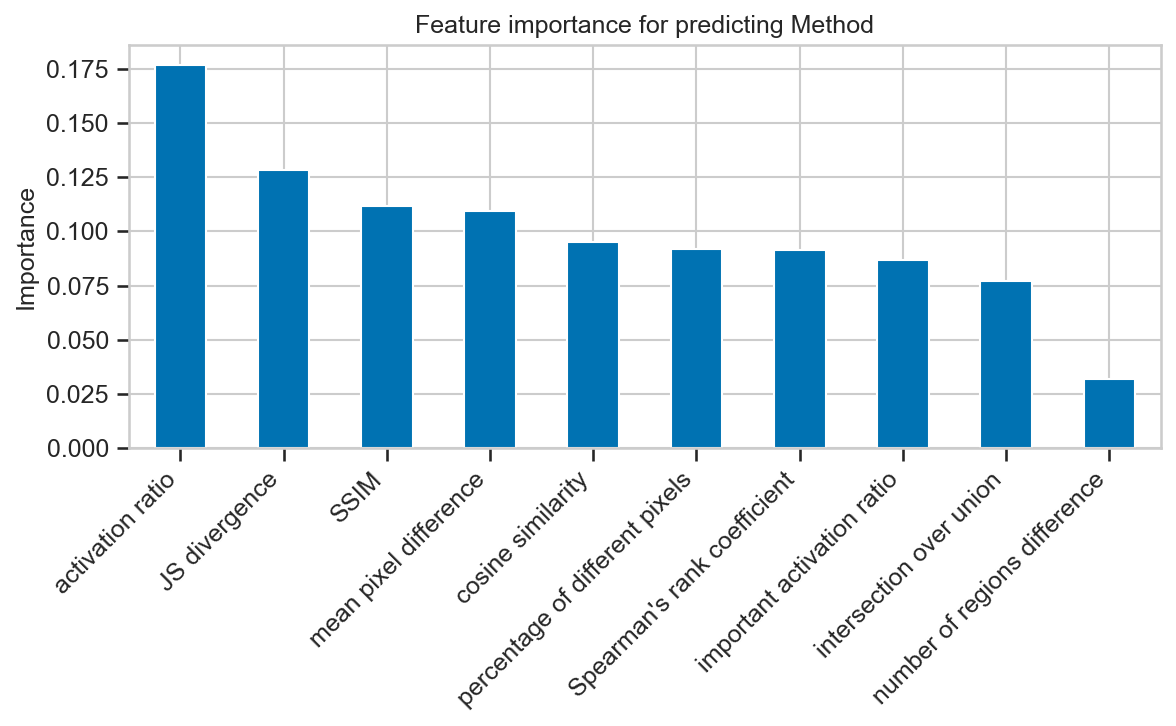

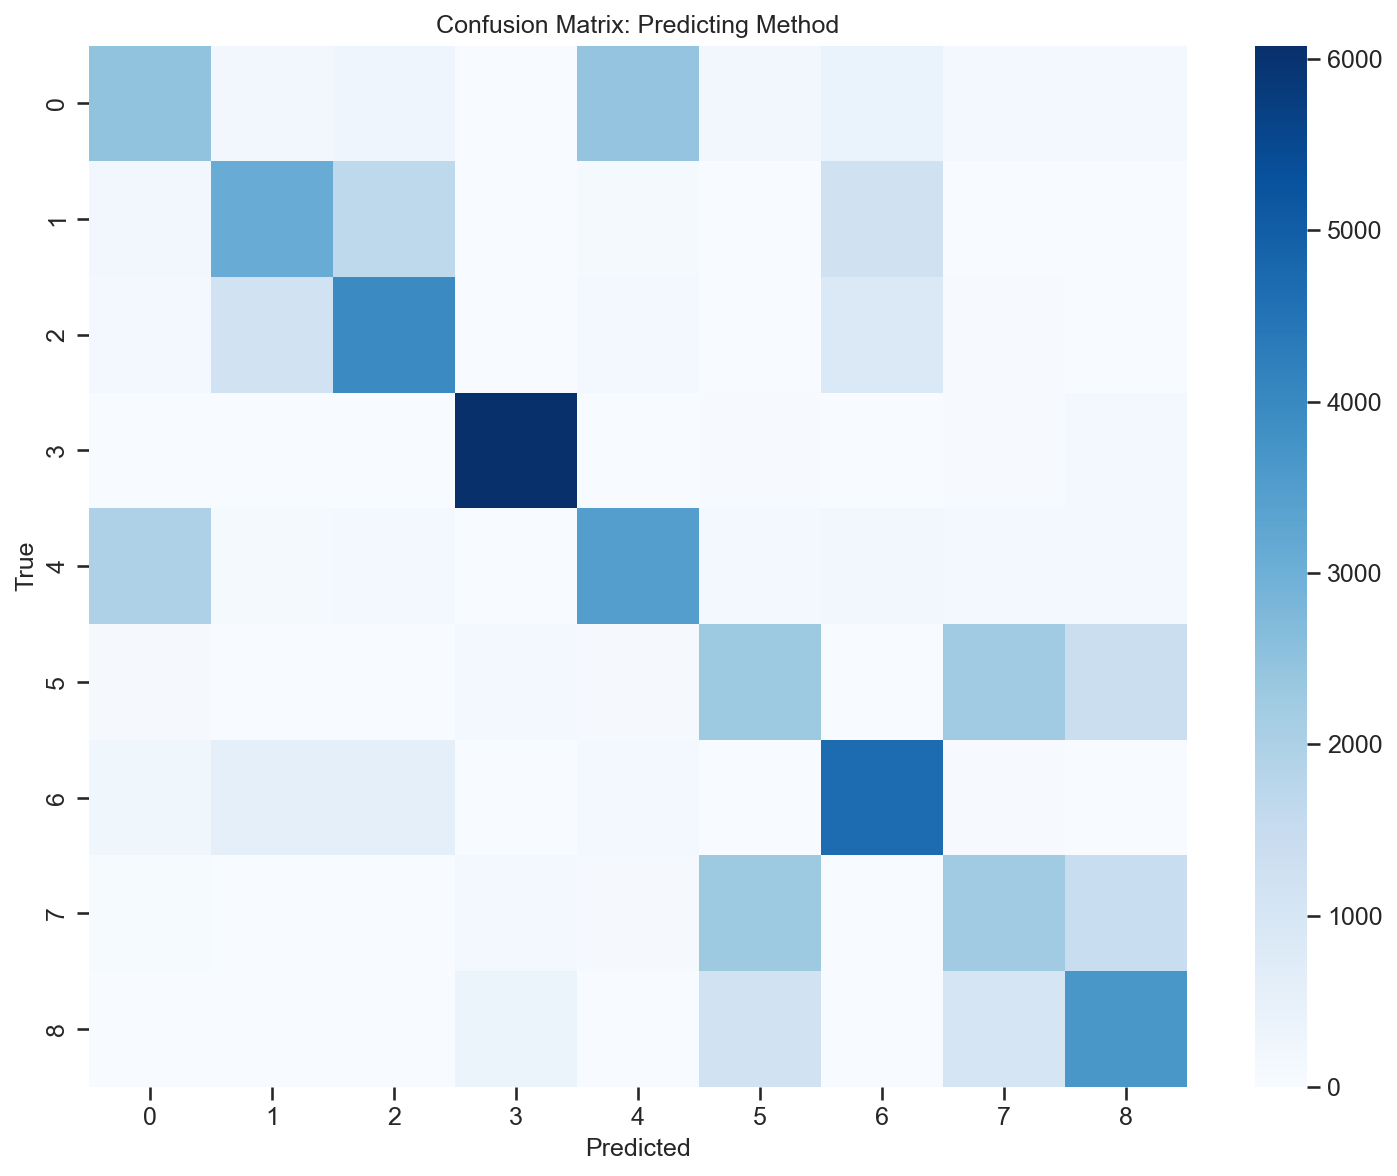

Including class information and score of predicted classes:

--- Predicting method ---
Accuracy: 0.567422191552984
              precision    recall  f1-score   support

           0       0.47      0.39      0.42      6280
           1       0.62      0.51      0.56      6280
           2       0.62      0.65      0.63      6280
           3       0.90      0.97      0.94      6279
           4       0.52      0.54      0.53      6279
           5       0.34      0.34      0.34      6280
           6       0.64      0.75      0.69      6279
           7       0.34      0.32      0.33      6280
           8       0.60      0.64      0.62      6280

    accuracy                           0.57     56517
   macro avg       0.56      0.57      0.56     56517
weighted avg       0.56      0.57      0.56     56517



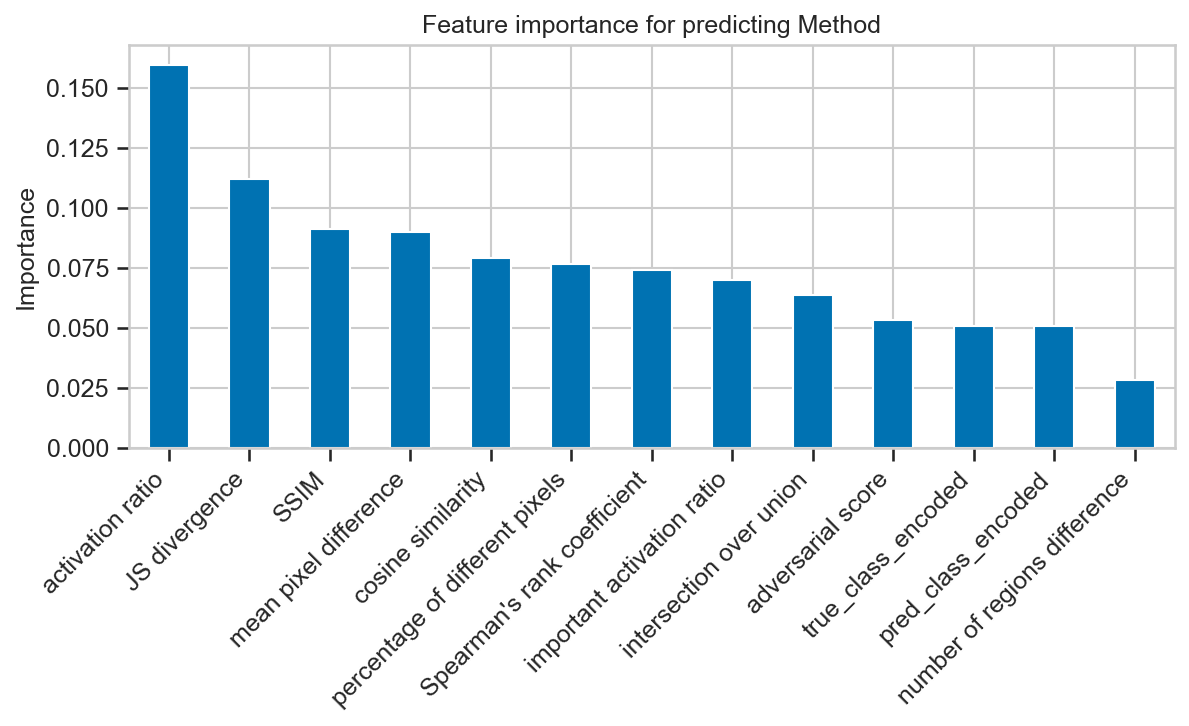

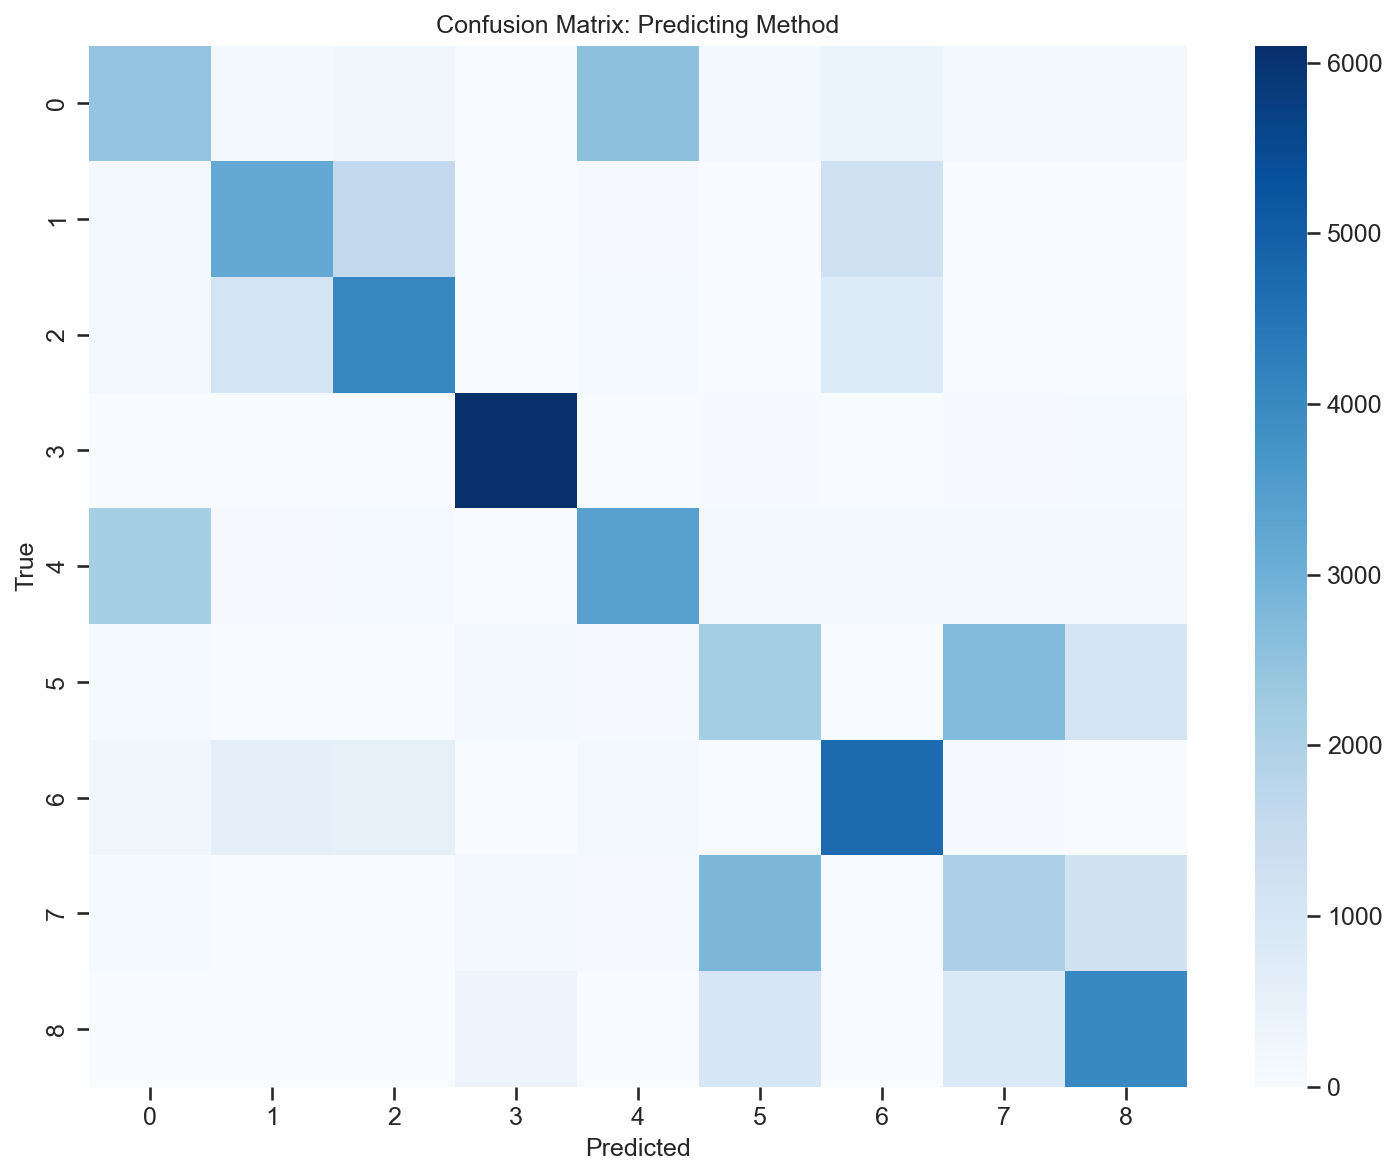

In [10]:
le_true = LabelEncoder()
le_pred = LabelEncoder()

results_df['true_class_encoded'] = le_true.fit_transform(results_df['true class'])
results_df['pred_class_encoded'] = le_pred.fit_transform(results_df['predicted class'])

# --- Run for method ---
run_rf_classification(results_df, "method", "Method", metric_columns)

print("Including class information and score of predicted classes:")

run_rf_classification(results_df, "method", "Method", metric_columns + ["true_class_encoded", "pred_class_encoded", "adversarial score"])

In [18]:
results_df.columns

Index(['image ID', 'method', 'attack', 'true class', 'predicted class',
       'images mean difference', 'original score', 'adversarial score',
       'mean pixel difference', 'percentage of different pixels',
       'number of regions original', 'number of regions adversarial',
       'cosine similarity', 'activation ratio', 'JS divergence',
       'important activation ratio', 'intersection over union', 'SSIM',
       'Spearman's rank coefficient', 'number of regions difference',
       'method_float', 'true_class_encoded', 'pred_class_encoded'],
      dtype='object')

# Distances witin distributions per method for clustering

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations
from scipy.special import kl_div
from adjustText import adjust_text

class AdversarialAnalysis:
    def __init__(self, results_df):
        """
        Initialize the analysis with your results dataframe
        """
        self.df = results_df
        self.metric_columns = [
            'mean pixel difference', 'activation ratio',  
            'important activation ratio', 'JS divergence',    
            'number of regions difference'
        ]
        self.methods = self.df['method'].unique()
        self.distance_matrices_per_metric = {}
        self.combined_distance_matrices = {}
        self.clustering_results = {}
        self.silhouette_scores = {}
        
    # Add these new methods inside your AdversarialAnalysis class

    def _get_binned_probabilities(self, p, q, bins=50):
        """Helper to create comparable probability distributions from raw data."""
        min_val = min(p.min(), q.min())
        max_val = max(p.max(), q.max())
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        
        # Normalize to ensure they are valid probability distributions
        hist_p /= np.sum(hist_p)
        hist_q /= np.sum(hist_q) 
        return hist_p, hist_q

    def jensen_shannon_divergence(self, p, q, bins=20):
        """
        Calculate Jensen-Shannon divergence between two distributions
        """
        # Create histograms with same bins
        min_val = min(np.min(p), np.min(q))
        max_val = max(np.max(p), np.max(q))
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        
        # Normalize to probabilities
        hist_p = hist_p / np.sum(hist_p)
        hist_q = hist_q / np.sum(hist_q)
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        hist_p = hist_p + epsilon
        hist_q = hist_q + epsilon
        
        # Calculate M = (P + Q) / 2
        m = (hist_p + hist_q) / 2
        
        # KL divergence
        def kl_divergence(x, y):
            return np.sum(x * np.log(x / y))
        
        # JS divergence
        js_div = 0.5 * kl_divergence(hist_p, m) + 0.5 * kl_divergence(hist_q, m)
        return js_div
    
    def calculate_distance_matrices_per_metric(self):
        """
        Calculate distance matrices for each metric separately
        """
        n_methods = len(self.methods)
        
        for metric in self.metric_columns:
            print(f"Calculating distances for {metric}...")
            
            # Initialize distance matrix
            js_matrix = np.zeros((n_methods, n_methods))
            
            # Get distributions for each method
            method_distributions = {}
            for method in self.methods:
                method_data = self.df[self.df['method'] == method][metric].dropna()
                if len(method_data) == 0:
                    print(f"Warning: No data for method {method} and metric {metric}")
                    continue
                method_distributions[method] = method_data.values
            
            # Calculate pairwise distances
            for i, method1 in enumerate(self.methods):
                for j, method2 in enumerate(self.methods):
                    if i == j:
                        js_matrix[i, j] = 0
                  
                    else:
                        if method1 in method_distributions and method2 in method_distributions:
                            dist1 = method_distributions[method1]
                            dist2 = method_distributions[method2]
                            
                            # Jensen-Shannon divergence
                            js_matrix[i, j] = self.jensen_shannon_divergence(dist1, dist2)

            self.distance_matrices_per_metric[metric] = {
                'jensen_shannon': js_matrix
            }
    
    def combine_distance_matrices(self, combination_method='average'):
        """
        Combine distance matrices across all metrics
        
        combination_method options:
        - 'average': Simple average of distances across metrics
        - 'weighted_average': Weighted by inverse of metric variance
        - 'max': Maximum distance across metrics
        - 'euclidean': Euclidean distance in metric space
        """
        n_methods = len(self.methods)
        n_metrics = len(self.metric_columns)

        for distance_type in ['jensen_shannon']:
            if combination_method == 'average':
                # Simple average
                combined_matrix = np.zeros((n_methods, n_methods))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        D = self.distance_matrices_per_metric[metric][distance_type]

                        # Compute robust min/max using percentiles
                        p_low, p_high = np.percentile(D, [0.05, 99.5])
                        D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)  # clip to [0,1]

                        combined_matrix += D_norm
                        #combined_matrix += self.distance_matrices_per_metric[metric][distance_type]
                combined_matrix /= len(self.metric_columns)
                
            elif combination_method == 'weighted_average':
                # Weighted by inverse variance of each metric
                weights = []
                matrices = []
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        # Calculate weight as inverse of variance
                        variance = np.var(matrix[matrix > 0])
                        weight = 1.0 / (variance + 1e-10)  # Add small epsilon to avoid division by zero
                        weights.append(weight)
                        matrices.append(matrix)
                
                weights = np.array(weights)
                weights = weights / np.sum(weights)  # Normalize weights
                
                combined_matrix = np.zeros((n_methods, n_methods))
                for weight, matrix in zip(weights, matrices):
                    combined_matrix += weight * matrix
                    
            elif combination_method == 'max':
                # Maximum distance across metrics
                combined_matrix = np.zeros((n_methods, n_methods))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        combined_matrix = np.maximum(combined_matrix, matrix)
                        
            elif combination_method == 'euclidean':
                # Euclidean distance in metric space
                combined_matrix = np.zeros((n_methods, n_methods))
                for i in range(n_methods):
                    for j in range(n_methods):
                        if i != j:
                            distances = []
                            for metric in self.metric_columns:
                                if metric in self.distance_matrices_per_metric:
                                    distances.append(self.distance_matrices_per_metric[metric][distance_type][i, j])
                            combined_matrix[i, j] = np.sqrt(np.sum(np.array(distances)**2))
            
            self.combined_distance_matrices[f"{distance_type}_{combination_method}"] = combined_matrix
            
        print(f"Combined distance matrices using {combination_method} method")
    
    def calculate_silhouette_scores(self, distance_matrix_key, max_clusters=8):
        """
        Calculate silhouette scores for different numbers of clusters
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        silhouette_scores = {}
        
        for n_clusters in range(2, min(len(self.methods), max_clusters + 1)):
            scores = {}
            
            # Hierarchical clustering
            linkage_matrix = linkage(squareform(distance_matrix), method='ward')
            hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            if len(np.unique(hier_labels)) == n_clusters:  # Check if we got the expected number of clusters
                scores['hierarchical'] = silhouette_score(distance_matrix, hier_labels, metric='precomputed')
            
            # Spectral clustering
            try:
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
                spec_labels = spectral.fit_predict(affinity_matrix)
                if len(np.unique(spec_labels)) == n_clusters:
                    scores['spectral'] = silhouette_score(distance_matrix, spec_labels, metric='precomputed')
            except Exception as e:
                print(f"Spectral clustering failed for {n_clusters} clusters: {e}")
            
            # Agglomerative clustering
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                       metric='precomputed', 
                                                       linkage='average')
                agg_labels = agg_clustering.fit_predict(distance_matrix)
                if len(np.unique(agg_labels)) == n_clusters:
                    scores['agglomerative'] = silhouette_score(distance_matrix, agg_labels, metric='precomputed')
            except Exception as e:
                print(f"Agglomerative clustering failed for {n_clusters} clusters: {e}")
            
            silhouette_scores[n_clusters] = scores
        
        self.silhouette_scores[distance_matrix_key] = silhouette_scores
        return silhouette_scores
    
    
    def perform_clustering_with_optimal_clusters(self, distance_matrix_key):
        """
        Perform clustering using optimal number of clusters based on silhouette scores
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        results = {}
        
        # Find optimal clusters for other methods
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        for method in ['hierarchical', 'spectral', 'agglomerative']:
            method_scores = {k: v.get(method, -1) for k, v in silhouette_data.items()}
            optimal_clusters = max(method_scores, key=method_scores.get)
            
            print(f"Optimal clusters for {method}: {optimal_clusters} (silhouette score: {method_scores[optimal_clusters]:.3f})")
            
            if method == 'hierarchical':
                linkage_matrix = linkage(squareform(distance_matrix), method='ward')
                labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters],
                    'linkage_matrix': linkage_matrix
                }
            elif method == 'spectral':
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=optimal_clusters, affinity='precomputed', 
                                            random_state=42)
                labels = spectral.fit_predict(affinity_matrix) + 1
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters]
                }
        
        self.clustering_results[distance_matrix_key] = results
        return results
    
    def plot_silhouette_analysis(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot silhouette scores for different numbers of clusters
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        plt.figure(figsize=figsize)

        methods = ['hierarchical', 'spectral']
        colors = ['blue', 'red']
        markers = ['o', 's']

        # Plot both methods on the same plot
        for idx, method in enumerate(methods):
            clusters = []
            scores = []
            for n_clusters, method_scores in silhouette_data.items():
                if method in method_scores:
                    clusters.append(n_clusters)
                    scores.append(method_scores[method])
            
            if clusters:
                plt.plot(clusters, scores, marker=markers[idx], color=colors[idx], 
                        linewidth=2, markersize=8, label=f'{method.title()} Clustering')

        plt.title(f'Silhouette score comparison')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/targeted/silhouette_analysis_{distance_matrix_key}_targeted.svg")
        plt.show()
    
    def plot_combined_distance_heatmap(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot heatmap of combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        plt.figure(figsize=figsize)
        sns.heatmap(distance_matrix, 
                   xticklabels=self.methods, yticklabels=self.methods,
                   annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Combined distance matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def plot_clustering_comparison(self, distance_matrix_key, figsize=(20, 6)):
        """
        Compare clustering results across different methods
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        results = self.clustering_results[distance_matrix_key]
        
        
        clustering_methods = ['hierarchical', 'spectral']
        fig, axes = plt.subplots(1, len(clustering_methods), figsize=figsize)
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        
        for idx, clustering_method in enumerate(clustering_methods):
            if clustering_method in results:
                labels = results[clustering_method]['labels']
                n_clusters = results[clustering_method]['n_clusters']
                
                # Create scatter plot showing cluster assignments
                x_pos = range(len(self.methods))
                
                for i, method in enumerate(self.methods):
                    cluster_id = labels[i] - 1 if hasattr(labels, '__getitem__') else labels - 1
                    axes[idx].scatter(i, cluster_id, c=colors[cluster_id % len(colors)], s=100, alpha=0.7)
                    axes[idx].text(i, cluster_id, method, rotation=45, ha='right', va='bottom', fontsize=8)
                
                title = f'{clustering_method.replace("_", " ").title()}\n({n_clusters} clusters)'
                if 'silhouette_score' in results[clustering_method]:
                    title += f'\nSil: {results[clustering_method]["silhouette_score"]:.3f}'
                
                axes[idx].set_title(title)
                axes[idx].set_xlabel('Methods', fontsize=11)
                axes[idx].set_ylabel('Cluster', fontsize=11)
                axes[idx].set_xticks(range(len(self.methods)))
                axes[idx].set_xticklabels(self.methods, rotation=45, ha='right')
                axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle(f'Clustering Comparison - {distance_matrix_key}')
        plt.tight_layout()
        plt.show()
    
    def plot_dendrogram(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot dendrogram for hierarchical clustering
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        plt.figure(figsize=figsize)
        linkage_matrix = self.clustering_results[distance_matrix_key]['hierarchical']['linkage_matrix']
        
        dendrogram(linkage_matrix, labels=self.methods, leaf_rotation=45, leaf_font_size=12)
        plt.title(f'Dendrogram of Hierarchical Clustering of methods for targeted attacks')
        plt.ylabel('Distance')
        plt.xlabel('Method')
        plt.xticks(ha='right')
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/targeted/dendrogram_{distance_matrix_key}_methods_targeted.svg")
        plt.show()
    
    def mds_visualization(self, distance_matrix_key, figsize=(8, 6)):
        """
        Visualize methods using MDS based on combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        # Perform MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(distance_matrix)

        
        # Get cluster colors if clustering results exist
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        if distance_matrix_key in self.clustering_results:
            # Use spectral clustering results for coloring
            labels = self.clustering_results[distance_matrix_key]['spectral']['labels']
            point_colors = [colors[(label - 1) % len(colors)] for label in labels]
        else:
            point_colors = 'blue'
        
        plt.figure(figsize=figsize)
        plt.scatter(coords[:, 0], coords[:, 1], s=100, alpha=0.7, c=point_colors)

        texts = []
        
        for i, method in enumerate(self.methods):
            texts.append(plt.annotate(method, (coords[i, 0], coords[i, 1]),
                     fontsize=10)
                )

        adjust_text(texts)
        plt.title(f'MDS visualization')
        plt.xlabel('MDS dimension 1')
        plt.ylabel('MDS dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def comprehensive_analysis(self, combination_methods=['average', 'weighted_average']):
        """
        Run comprehensive analysis with all combination methods
        """
        print("=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===\n")
        
        # Calculate distance matrices per metric
        self.calculate_distance_matrices_per_metric()
        
        # Try different combination methods
        for comb_method in combination_methods:
            print(f"\n{'='*60}")
            print(f"ANALYSIS WITH {comb_method.upper()} COMBINATION METHOD")
            print('='*60)
            
            # Combine matrices
            self.combine_distance_matrices(comb_method)
            
            # Analyze both distance types
            for distance_type in ['jensen_shannon']:
                matrix_key = f"{distance_type}_{comb_method}"
                
                print(f"\n--- {distance_type.title()} Distance ---")
                
                # Plot combined distance heatmap
                self.plot_combined_distance_heatmap(matrix_key)
                
                # Calculate silhouette scores
                self.calculate_silhouette_scores(matrix_key)
                
                # Plot silhouette analysis
                self.plot_silhouette_analysis(matrix_key)
                
                # Perform clustering with optimal number of clusters
                results = self.perform_clustering_with_optimal_clusters(matrix_key)
                
                # Visualizations
                self.plot_clustering_comparison(matrix_key)
                self.plot_dendrogram(matrix_key)
                self.mds_visualization(matrix_key)
                
                # Print summary
                print(f"\nClustering Summary for {matrix_key}:")
                for method, result in results.items():
                    print(f"  {method}: {result['n_clusters']} clusters", end="")
                    if 'silhouette_score' in result:
                        print(f" (silhouette: {result['silhouette_score']:.3f})", end="")

    
    def summary_report(self):
        """
        Generate a summary report
        """
        print("=== ADVERSARIAL ATTACK ANALYSIS SUMMARY ===\n")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Number of methods: {len(self.methods)}")
        print(f"Methods: {', '.join(self.methods)}")
        print(f"Number of attacks: {len(self.df['attack'].unique())}")
        print(f"Attacks: {', '.join(self.df['attack'].unique())}")
        print(f"Number of images: {len(self.df['image ID'].unique())}")
        print(f"Metrics analyzed: {len(self.metric_columns)}")
        
        print("\n=== BASIC STATISTICS ===")
        for metric in self.metric_columns:
            print(f"\n{metric}:")
            stats_df = self.df.groupby('method')[metric].agg(['count', 'mean', 'std', 'median']).round(4)
            print(stats_df)


=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===

Calculating distances for mean pixel difference...
Calculating distances for activation ratio...
Calculating distances for important activation ratio...
Calculating distances for JS divergence...
Calculating distances for number of regions difference...

ANALYSIS WITH AVERAGE COMBINATION METHOD
Combined distance matrices using average method

--- Jensen_Shannon Distance ---


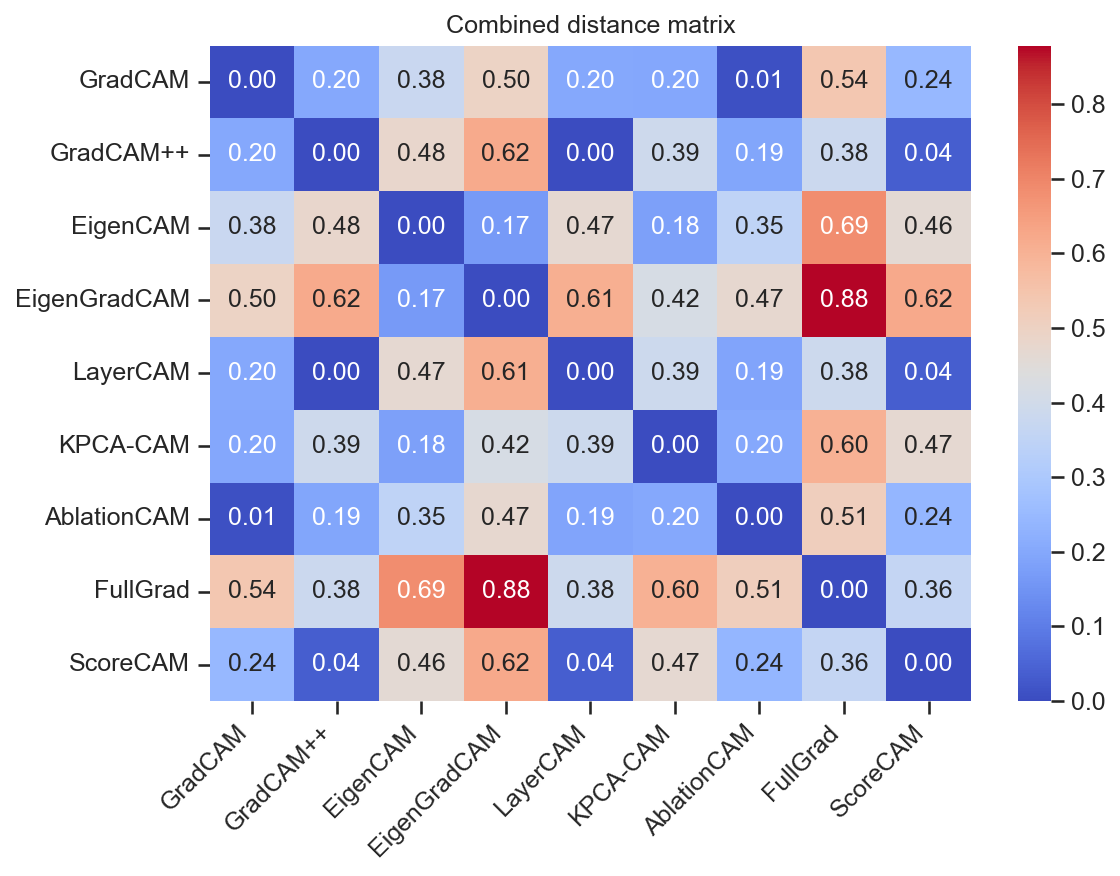

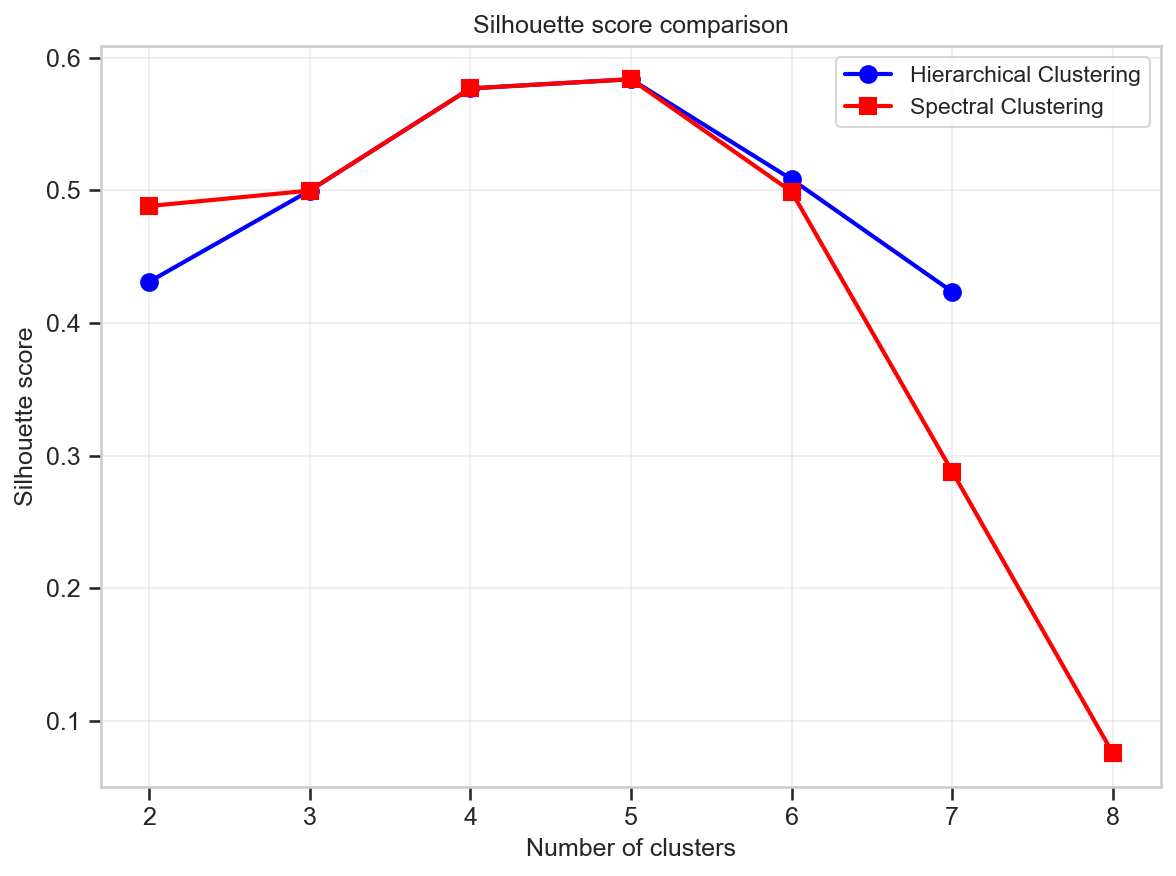

Optimal clusters for hierarchical: 5 (silhouette score: 0.584)
Optimal clusters for spectral: 5 (silhouette score: 0.584)
Optimal clusters for agglomerative: 5 (silhouette score: 0.584)


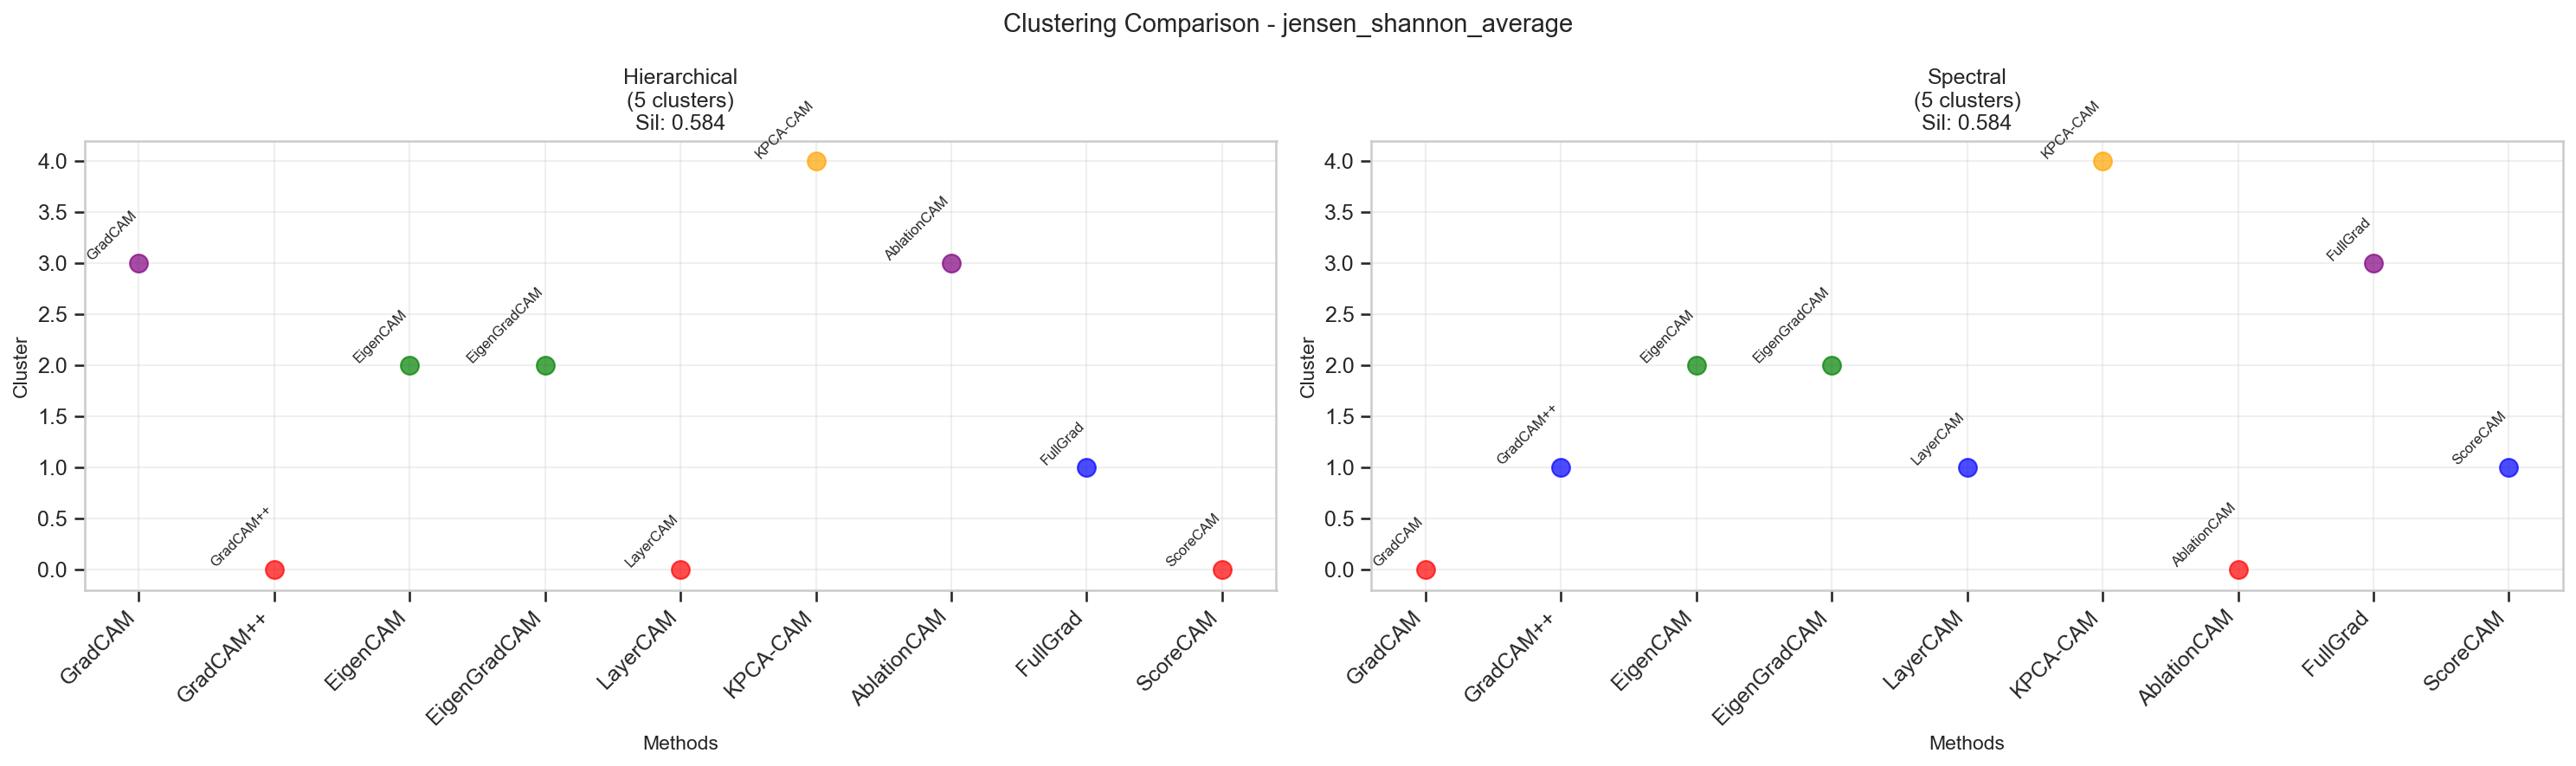

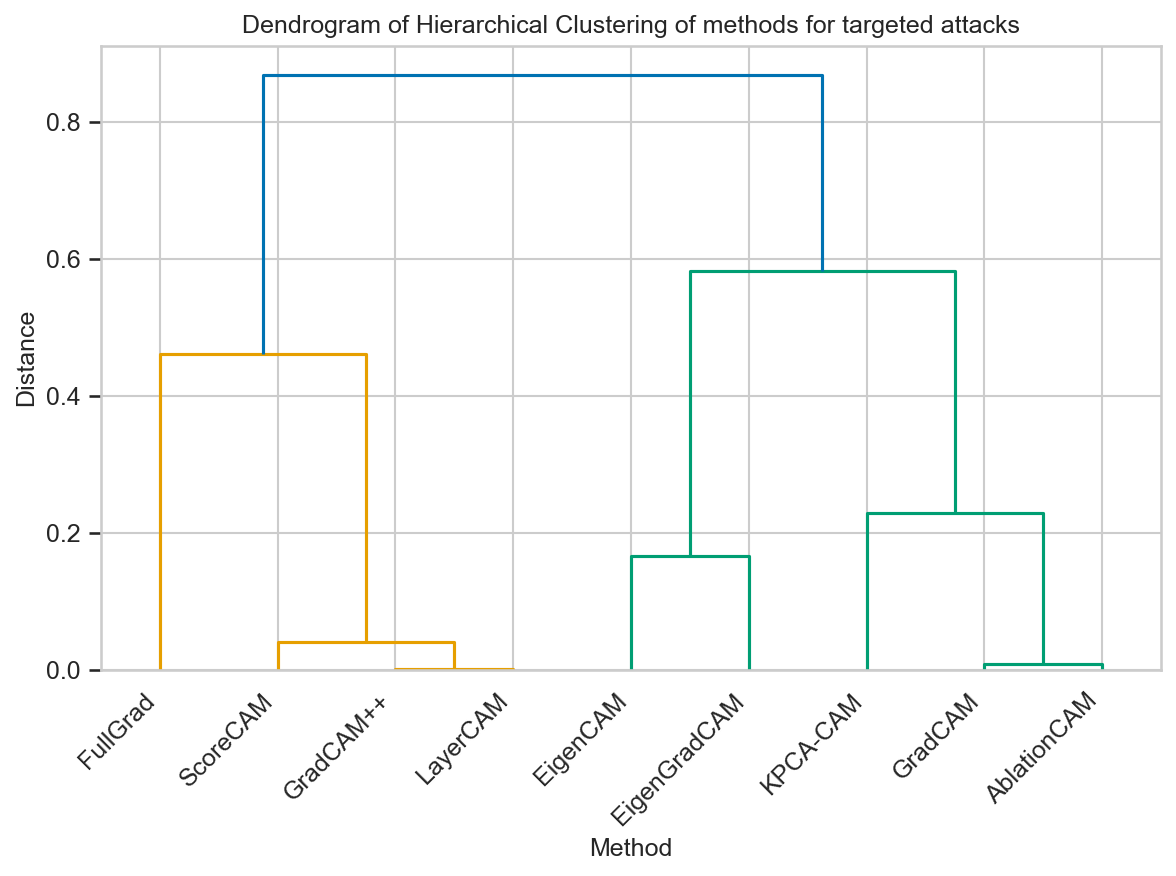

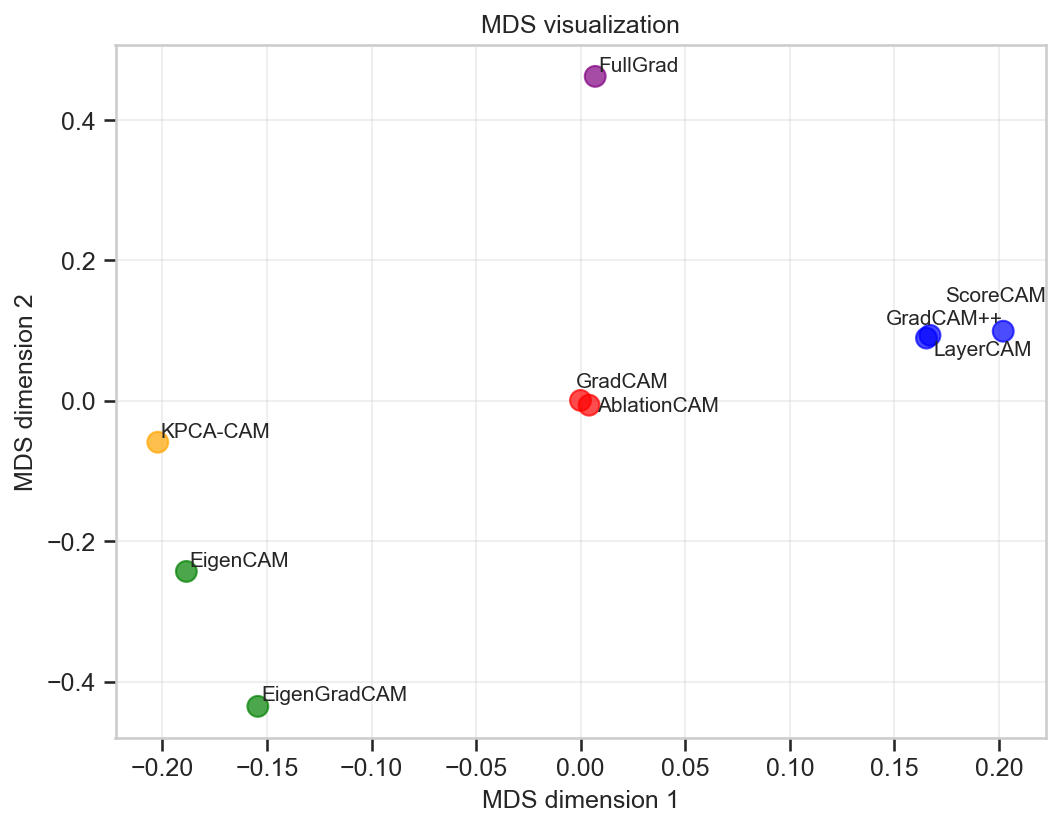


Clustering Summary for jensen_shannon_average:
  hierarchical: 5 clusters (silhouette: 0.584)  spectral: 5 clusters (silhouette: 0.584)

In [32]:
# Initialize the analysis
analyzer = AdversarialAnalysis(results_df)

# Run comprehensive analysis
analyzer.comprehensive_analysis(['average'])

In [21]:
analyzer.clustering_results

{'jensen_shannon_average': {'hierarchical': {'labels': array([4, 1, 3, 3, 1, 5, 4, 2, 1], dtype=int32),
   'n_clusters': 5,
   'silhouette_score': 0.5839019063423008,
   'linkage_matrix': array([[1.00000000e+00, 4.00000000e+00, 1.78305494e-03, 2.00000000e+00],
          [0.00000000e+00, 6.00000000e+00, 8.50924100e-03, 2.00000000e+00],
          [8.00000000e+00, 9.00000000e+00, 4.11586374e-02, 3.00000000e+00],
          [2.00000000e+00, 3.00000000e+00, 1.66533363e-01, 2.00000000e+00],
          [5.00000000e+00, 1.00000000e+01, 2.28398997e-01, 3.00000000e+00],
          [7.00000000e+00, 1.10000000e+01, 4.60382911e-01, 4.00000000e+00],
          [1.20000000e+01, 1.30000000e+01, 5.81389432e-01, 5.00000000e+00],
          [1.40000000e+01, 1.50000000e+01, 8.67766518e-01, 9.00000000e+00]])},
  'spectral': {'labels': array([1, 2, 3, 3, 2, 5, 1, 4, 2], dtype=int32),
   'n_clusters': 5,
   'silhouette_score': 0.5839019063423008}}}

In [22]:
analyzer.methods

array(['GradCAM', 'GradCAM++', 'EigenCAM', 'EigenGradCAM', 'LayerCAM',
       'KPCA-CAM', 'AblationCAM', 'FullGrad', 'ScoreCAM'], dtype=object)

# use random forest classifier to predict clusters based on the metrics

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [14]:
# add cluster information to dataframe

# map label to method
method_to_label = {method: label for label, method in zip(analyzer.clustering_results["jensen_shannon_average"]["hierarchical"]["labels"], analyzer.methods)}
results_df["cluster"] = results_df["method"].map(method_to_label)


--- Predicting cluster ---
Accuracy: 0.8650671479377886
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     18839
           1       0.94      0.93      0.93      6280
           2       0.81      0.83      0.82     12559
           3       0.87      0.85      0.86     12559
           4       0.69      0.63      0.66      6280

    accuracy                           0.87     56517
   macro avg       0.85      0.84      0.84     56517
weighted avg       0.86      0.87      0.86     56517



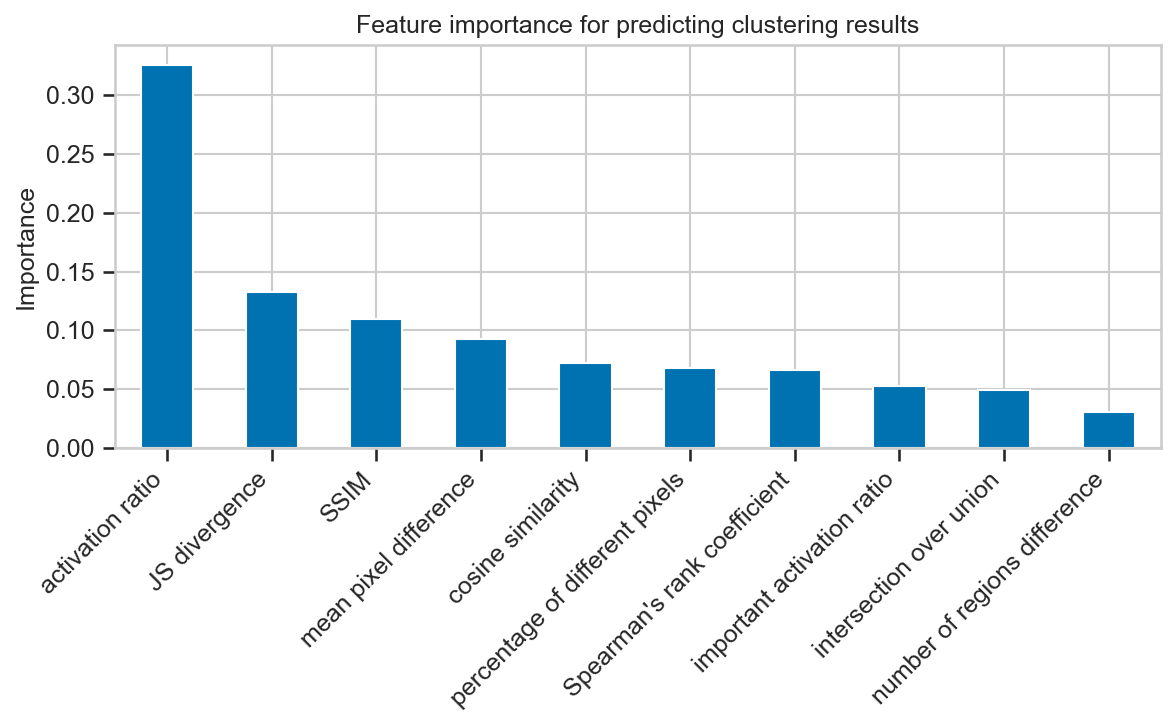

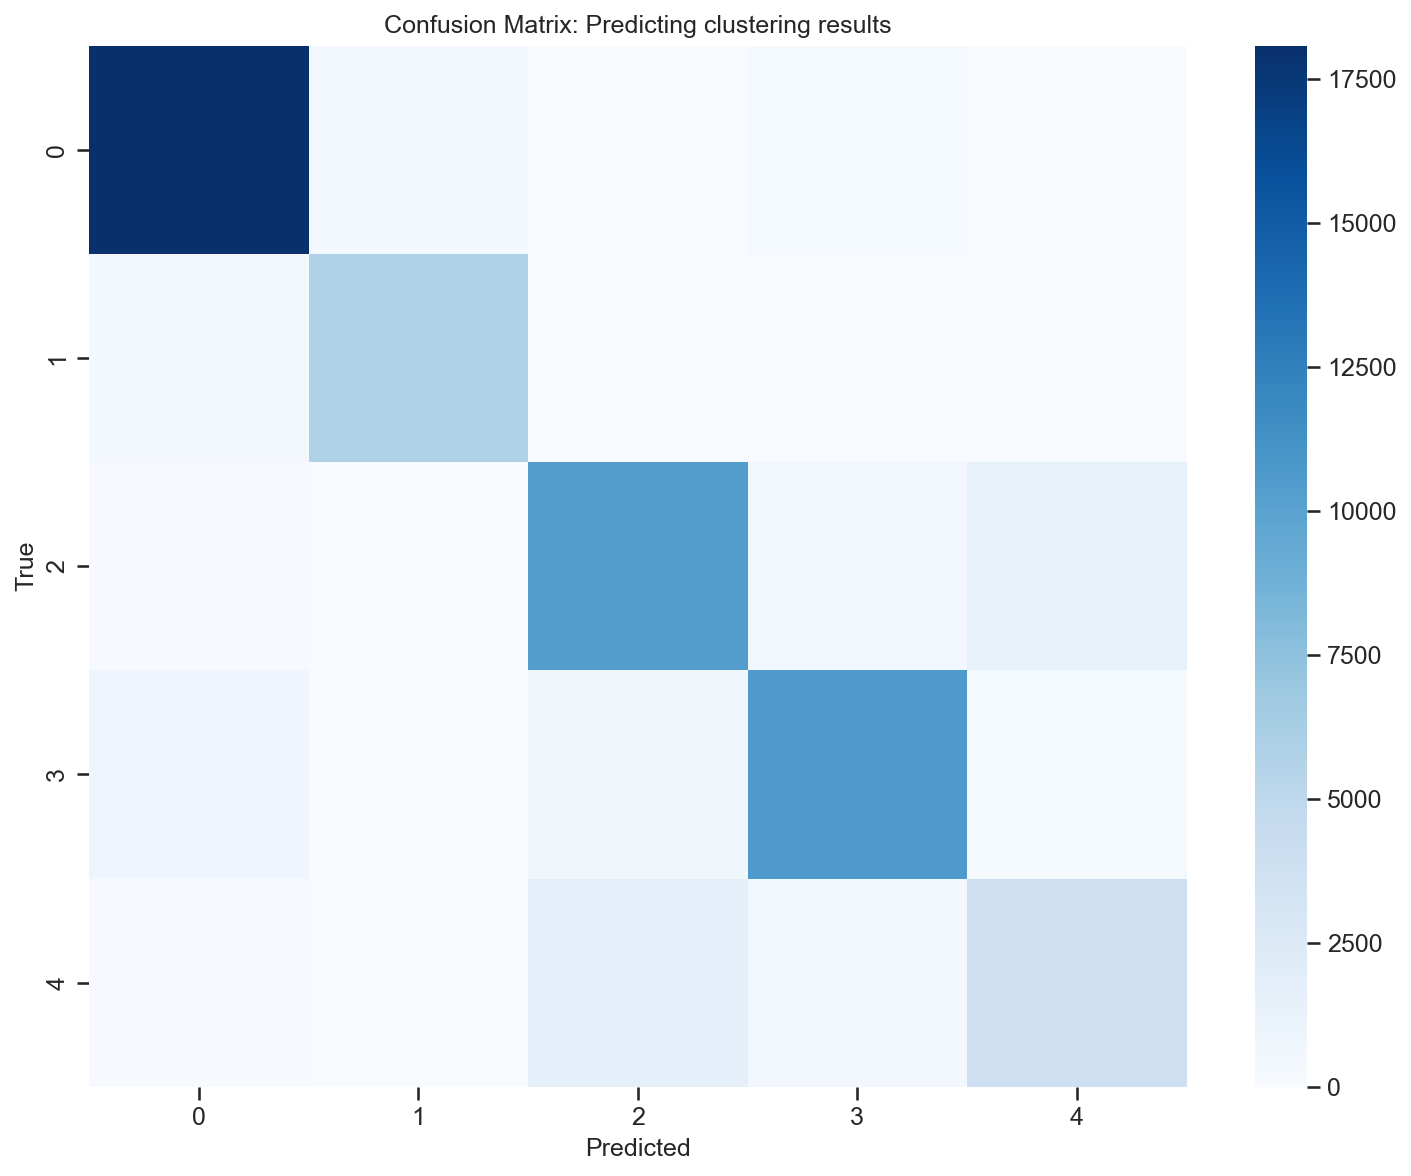

In [16]:
run_rf_classification(results_df, "cluster", "clustering results", metric_columns, save_plot=True)

## Attacks

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations
from scipy.special import kl_div
from adjustText import adjust_text

class AdversarialAttacksAnalysis:
    def __init__(self, results_df):
        """
        Initialize the analysis with your results dataframe
        """
        self.df = results_df
        self.metric_columns = [
            'mean pixel difference', 'activation ratio', 
            'important activation ratio', 'JS divergence',    
            'number of regions difference'
        ]

        self.attacks = self.df['attack'].unique()
        self.distance_matrices_per_metric = {}
        self.combined_distance_matrices = {}
        self.clustering_results = {}
        self.silhouette_scores = {}


    def jensen_shannon_divergence(self, p, q, bins=20):
        """
        Calculate Jensen-Shannon divergence between two distributions
        """
        # Create histograms with same bins
        min_val = min(np.min(p), np.min(q))
        max_val = max(np.max(p), np.max(q))
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        
        # Normalize to probabilities
        hist_p = hist_p / np.sum(hist_p)
        hist_q = hist_q / np.sum(hist_q)
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        hist_p = hist_p + epsilon
        hist_q = hist_q + epsilon
        
        # Calculate M = (P + Q) / 2
        m = (hist_p + hist_q) / 2
        
        # KL divergence
        def kl_divergence(x, y):
            return np.sum(x * np.log(x / y))
        
        # JS divergence
        js_div = 0.5 * kl_divergence(hist_p, m) + 0.5 * kl_divergence(hist_q, m)
        return js_div
    
    def calculate_distance_matrices_per_metric(self):
        """
        Calculate distance matrices for each metric separately
        """
        n_attacks = len(self.attacks)
        
        for metric in self.metric_columns:
            print(f"Calculating distances for {metric}...")
            
            # Initialize distance matrices
            js_matrix = np.zeros((n_attacks, n_attacks))

            # Get distributions for each attack
            attack_distributions = {}
            for attack in self.attacks:
                attack_data = self.df[self.df['attack'] == attack][metric].dropna()
                if len(attack_data) == 0:
                    print(f"Warning: No data for attack {attack} and metric {metric}")
                    continue
                attack_distributions[attack] = attack_data.values

            # Calculate pairwise distances
            for i, attack1 in enumerate(self.attacks):
                for j, attack2 in enumerate(self.attacks):
                    if i == j:
                        js_matrix[i, j] = 0
                  
                    else:
                        if attack1 in attack_distributions and attack2 in attack_distributions:
                            dist1 = attack_distributions[attack1]
                            dist2 = attack_distributions[attack2]

                            # Jensen-Shannon divergence
                            js_matrix[i, j] = self.jensen_shannon_divergence(dist1, dist2)

              
            self.distance_matrices_per_metric[metric] = {
                'jensen_shannon': js_matrix
            }
    
    def combine_distance_matrices(self, combination_method='average'):
        """
        Combine distance matrices across all metrics
        
        combination_method options:
        - 'average': Simple average of distances across metrics
        - 'weighted_average': Weighted by inverse of metric variance
        - 'max': Maximum distance across metrics
        - 'euclidean': Euclidean distance in metric space
        """
        n_attacks = len(self.attacks)
        n_metrics = len(self.metric_columns)

        for distance_type in ['jensen_shannon']:
            if combination_method == 'average':
                # Simple average
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        D = self.distance_matrices_per_metric[metric][distance_type]

                        # Compute robust min/max using percentiles
                        p_low, p_high = np.percentile(D, [0.05, 99.5])
                        D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)  # clip to [0,1]

                        combined_matrix += D_norm
                        #combined_matrix += self.distance_matrices_per_metric[metric][distance_type]
                combined_matrix /= len(self.metric_columns)
                
            elif combination_method == 'weighted_average':
                # Weighted by inverse variance of each metric
                weights = []
                matrices = []
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        # Calculate weight as inverse of variance
                        variance = np.var(matrix[matrix > 0])
                        weight = 1.0 / (variance + 1e-10)  # Add small epsilon to avoid division by zero
                        weights.append(weight)
                        matrices.append(matrix)
                
                weights = np.array(weights)
                weights = weights / np.sum(weights)  # Normalize weights

                combined_matrix = np.zeros((n_attacks, n_attacks))
                for weight, matrix in zip(weights, matrices):
                    combined_matrix += weight * matrix
                    
            elif combination_method == 'max':
                # Maximum distance across metrics
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        combined_matrix = np.maximum(combined_matrix, matrix)
                        
            elif combination_method == 'euclidean':
                # Euclidean distance in metric space
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for i in range(n_attacks):
                    for j in range(n_attacks):
                        if i != j:
                            distances = []
                            for metric in self.metric_columns:
                                if metric in self.distance_matrices_per_metric:
                                    distances.append(self.distance_matrices_per_metric[metric][distance_type][i, j])
                            combined_matrix[i, j] = np.sqrt(np.sum(np.array(distances)**2))
            
            self.combined_distance_matrices[f"{distance_type}_{combination_method}"] = combined_matrix
            
        print(f"Combined distance matrices using {combination_method} method")
    
    def calculate_silhouette_scores(self, distance_matrix_key, max_clusters=33):
        """
        Calculate silhouette scores for different numbers of clusters
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        silhouette_scores = {}
        
        for n_clusters in range(2, min(len(self.attacks), max_clusters + 1)):
            scores = {}
            
            # Hierarchical clustering
            linkage_matrix = linkage(squareform(distance_matrix), method='ward')
            hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            if len(np.unique(hier_labels)) == n_clusters:  # Check if we got the expected number of clusters
                scores['hierarchical'] = silhouette_score(distance_matrix, hier_labels, metric='precomputed')
            
            # Spectral clustering
            try:
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
                spec_labels = spectral.fit_predict(affinity_matrix)
                if len(np.unique(spec_labels)) == n_clusters:
                    scores['spectral'] = silhouette_score(distance_matrix, spec_labels, metric='precomputed')
            except Exception as e:
                print(f"Spectral clustering failed for {n_clusters} clusters: {e}")
            
            # Agglomerative clustering
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                       metric='precomputed', 
                                                       linkage='average')
                agg_labels = agg_clustering.fit_predict(distance_matrix)
                if len(np.unique(agg_labels)) == n_clusters:
                    scores['agglomerative'] = silhouette_score(distance_matrix, agg_labels, metric='precomputed')
            except Exception as e:
                print(f"Agglomerative clustering failed for {n_clusters} clusters: {e}")
            
            silhouette_scores[n_clusters] = scores
        
        self.silhouette_scores[distance_matrix_key] = silhouette_scores
        return silhouette_scores
    
    
    def perform_clustering_with_optimal_clusters(self, distance_matrix_key, num_clusters=None):
        """
        Perform clustering using optimal number of clusters based on silhouette scores
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        results = {}
        
        # Find optimal clusters for other methods
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        for method in ['hierarchical', 'spectral', 'agglomerative']:
            method_scores = {k: v.get(method, -1) for k, v in silhouette_data.items()}
            if num_clusters is not None:
                optimal_clusters = num_clusters
            else:
                optimal_clusters = max(method_scores, key=method_scores.get)

            print(f"Optimal clusters for {method}: {optimal_clusters} (silhouette score: {method_scores[optimal_clusters]:.3f})")
            
            if method == 'hierarchical':
                linkage_matrix = linkage(squareform(distance_matrix), method='ward')
                labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters],
                    'linkage_matrix': linkage_matrix
                }
            elif method == 'spectral':
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=optimal_clusters, affinity='precomputed', 
                                            random_state=42)
                labels = spectral.fit_predict(affinity_matrix) + 1
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters]
                }
        
        self.clustering_results[distance_matrix_key] = results
        return results
    
    def plot_silhouette_analysis(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot silhouette scores for different numbers of clusters
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        plt.figure(figsize=figsize)

        methods = ['hierarchical', 'spectral']
        colors = ['blue', 'red']
        markers = ['o', 's']

        # Plot both methods on the same plot
        for idx, method in enumerate(methods):
            clusters = []
            scores = []
            for n_clusters, method_scores in silhouette_data.items():
                if method in method_scores:
                    clusters.append(n_clusters)
                    scores.append(method_scores[method])
            
            if clusters:
                plt.plot(clusters, scores, marker=markers[idx], color=colors[idx], 
                        linewidth=2, markersize=8, label=f'{method.title()} Clustering')

        plt.title(f'Silhouette score comparison')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/targeted/silhouette_analysis_{distance_matrix_key}_attacks_targeted.svg")
        plt.show()
    
    def plot_combined_distance_heatmap(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot heatmap of combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        plt.figure(figsize=figsize)
        sns.heatmap(distance_matrix, 
                   xticklabels=self.attacks, yticklabels=self.attacks,
                   annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Combined distance matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/targeted/combined_distance_heatmap_{distance_matrix_key}_attacks_targeted.svg")
        plt.show()
    
    def plot_clustering_comparison(self, distance_matrix_key, figsize=(20, 6)):
        """
        Compare clustering results across different methods
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        results = self.clustering_results[distance_matrix_key]
        
        
        clustering_methods = ['hierarchical', 'spectral']
        fig, axes = plt.subplots(1, len(clustering_methods), figsize=figsize)
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        
        for idx, clustering_method in enumerate(clustering_methods):
            if clustering_method in results:
                labels = results[clustering_method]['labels']
                n_clusters = results[clustering_method]['n_clusters']
                
                # Create scatter plot showing cluster assignments
                x_pos = range(len(self.attacks))

                for i, attack in enumerate(self.attacks):
                    cluster_id = labels[i] - 1 if hasattr(labels, '__getitem__') else labels - 1
                    axes[idx].scatter(i, cluster_id, c=colors[cluster_id % len(colors)], s=100, alpha=0.7)
                    axes[idx].text(i, cluster_id, attack, rotation=45, ha='right', va='bottom', fontsize=8)

                title = f'{clustering_method.replace("_", " ").title()}\n({n_clusters} clusters)'
                if 'silhouette_score' in results[clustering_method]:
                    title += f'\nSil: {results[clustering_method]["silhouette_score"]:.3f}'
                
                axes[idx].set_title(title)
                axes[idx].set_xlabel('Attacks')
                axes[idx].set_ylabel('Cluster')
                axes[idx].set_xticks(range(len(self.attacks)))
                axes[idx].set_xticklabels(self.attacks, rotation=45, ha='right')
                axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle(f'Clustering Comparison - {distance_matrix_key}')
        plt.tight_layout()
        plt.show()
    
    def plot_dendrogram(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot dendrogram for hierarchical clustering
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        plt.figure(figsize=figsize)
        linkage_matrix = self.clustering_results[distance_matrix_key]['hierarchical']['linkage_matrix']
        
        dendrogram(linkage_matrix, labels=self.attacks, leaf_rotation=45, leaf_font_size=12)
        plt.title(f'Dendrogram of Hierarchical Clusterin of targeted attacks')
        plt.ylabel('Distance')
        plt.xlabel('Method')
        plt.xticks(ha='right')
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/targeted/dendrogram_{distance_matrix_key}_attacks_targeted.svg")
        plt.show()
    
    def mds_visualization(self, distance_matrix_key, figsize=(8, 6)):
        """
        Visualize methods using MDS based on combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        # Perform MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(distance_matrix)
        
        # Get cluster colors if clustering results exist
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        if distance_matrix_key in self.clustering_results:
            # Use spectral clustering results for coloring
            labels = self.clustering_results[distance_matrix_key]['spectral']['labels']
            point_colors = [colors[(label - 1) % len(colors)] for label in labels]
        else:
            point_colors = 'blue'
        
        plt.figure(figsize=figsize)
        plt.scatter(coords[:, 0], coords[:, 1], s=100, alpha=0.7, c=point_colors)

        texts = []

        for i, attack in enumerate(self.attacks):
            texts.append(plt.annotate(attack, (coords[i, 0], coords[i, 1]),
                     fontsize=10)
                )

        adjust_text(texts)
        plt.title(f'MDS visualization')
        plt.xlabel('MDS dimension 1')
        plt.ylabel('MDS dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def comprehensive_analysis(self, combination_methods=['average', 'weighted_average']):
        """
        Run comprehensive analysis with all combination methods
        """
        print("=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===\n")
        
        # Calculate distance matrices per metric
        self.calculate_distance_matrices_per_metric()
        
        # Try different combination methods
        for comb_method in combination_methods:
            print(f"\n{'='*60}")
            print(f"ANALYSIS WITH {comb_method.upper()} COMBINATION METHOD")
            print('='*60)
            
            # Combine matrices
            self.combine_distance_matrices(comb_method)
            
            # Analyze both distance types
            for distance_type in ['jensen_shannon']:
                matrix_key = f"{distance_type}_{comb_method}"
                
                print(f"\n--- {distance_type.title()} Distance ---")
                
                # Plot combined distance heatmap
                self.plot_combined_distance_heatmap(matrix_key)
                
                # Calculate silhouette scores
                self.calculate_silhouette_scores(matrix_key)
                
                # Plot silhouette analysis
                self.plot_silhouette_analysis(matrix_key)
                
                # Perform clustering with optimal number of clusters
                results = self.perform_clustering_with_optimal_clusters(matrix_key)
                
                # Visualizations
                self.plot_clustering_comparison(matrix_key)
                self.plot_dendrogram(matrix_key)
                self.mds_visualization(matrix_key)
                
                # Print summary
                print(f"\nClustering Summary for {matrix_key}:")
                for method, result in results.items():
                    print(f"  {method}: {result['n_clusters']} clusters", end="")
                    if 'silhouette_score' in result:
                        print(f" (silhouette: {result['silhouette_score']:.3f})", end="")

    def summary_report(self):
        """
        Generate a summary report
        """
        print("=== ADVERSARIAL ATTACK ANALYSIS SUMMARY ===\n")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Number of attacks: {len(self.attacks)}")
        print(f"Attacks: {', '.join(self.attacks)}")
        print(f"Number of images: {len(self.df['image ID'].unique())}")
        print(f"Metrics analyzed: {len(self.metric_columns)}")
        
        print("\n=== BASIC STATISTICS ===")
        for metric in self.metric_columns:
            print(f"\n{metric}:")
            stats_df = self.df.groupby('method')[metric].agg(['count', 'mean', 'std', 'median']).round(4)
            print(stats_df)


In [26]:
# filter dataframe such that every attack has the same number of samples (common image IDs)
# Get all unique attacks
all_attacks = results_df['attack'].unique()

# For each attack, find the set of image IDs that have results
image_sets_per_attack = [
    set(results_df[results_df['attack'] == attack]['image ID'].unique())
    for attack in all_attacks
]

# Intersection: images common to all attacks
common_image_ids = set.intersection(*image_sets_per_attack)
print(f"Number of images with successful adversarial examples for all attacks: {len(common_image_ids)}")
attack_df = results_df[results_df['image ID'].isin(common_image_ids)].copy()

Number of images with successful adversarial examples for all attacks: 1904


=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===

Calculating distances for mean pixel difference...
Calculating distances for activation ratio...
Calculating distances for important activation ratio...
Calculating distances for JS divergence...
Calculating distances for number of regions difference...

ANALYSIS WITH AVERAGE COMBINATION METHOD
Combined distance matrices using average method

--- Jensen_Shannon Distance ---


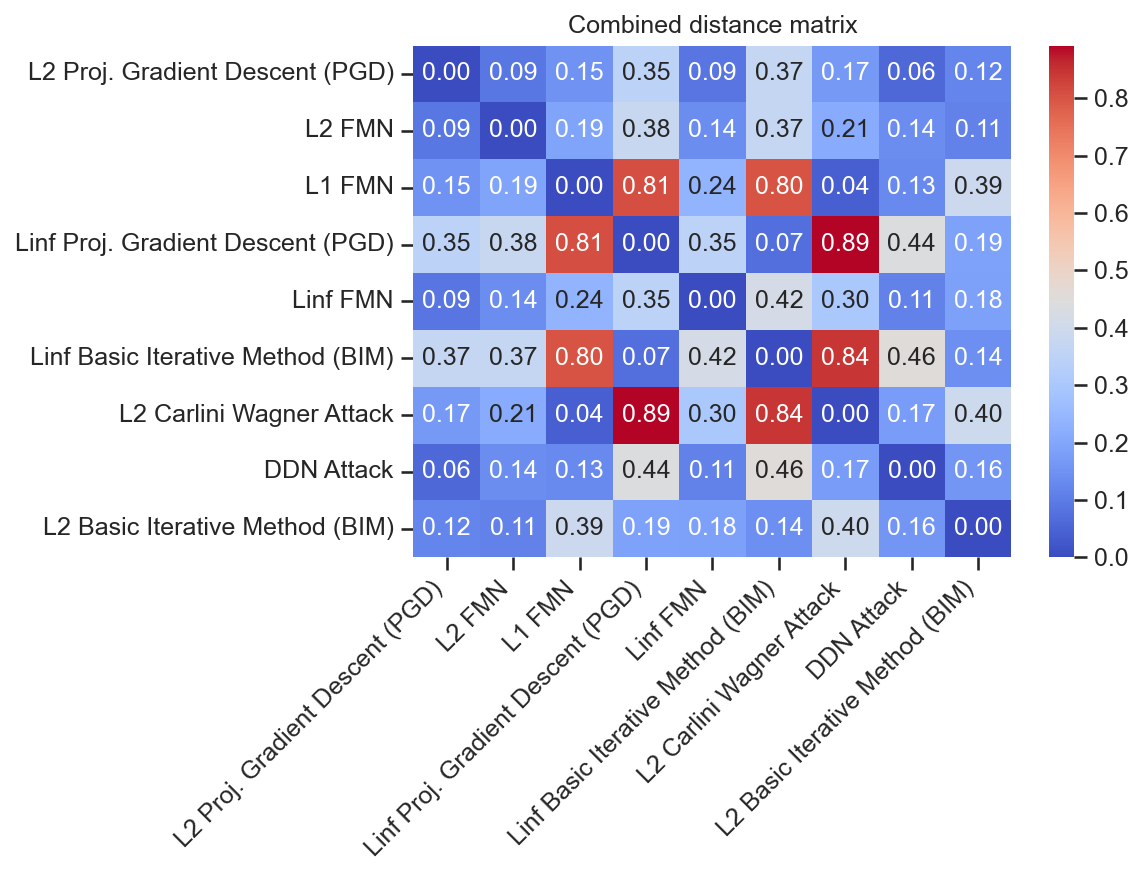

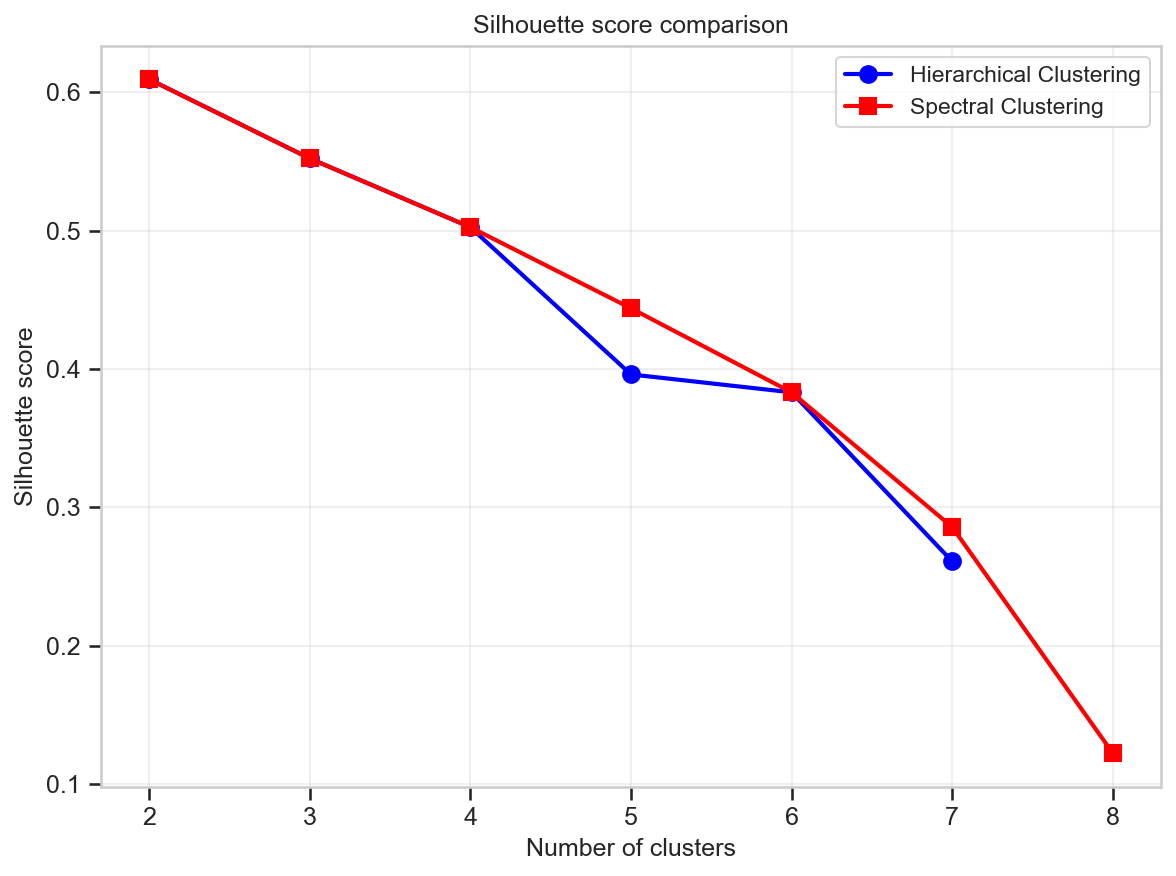

Optimal clusters for hierarchical: 2 (silhouette score: 0.609)
Optimal clusters for spectral: 2 (silhouette score: 0.609)
Optimal clusters for agglomerative: 2 (silhouette score: 0.609)


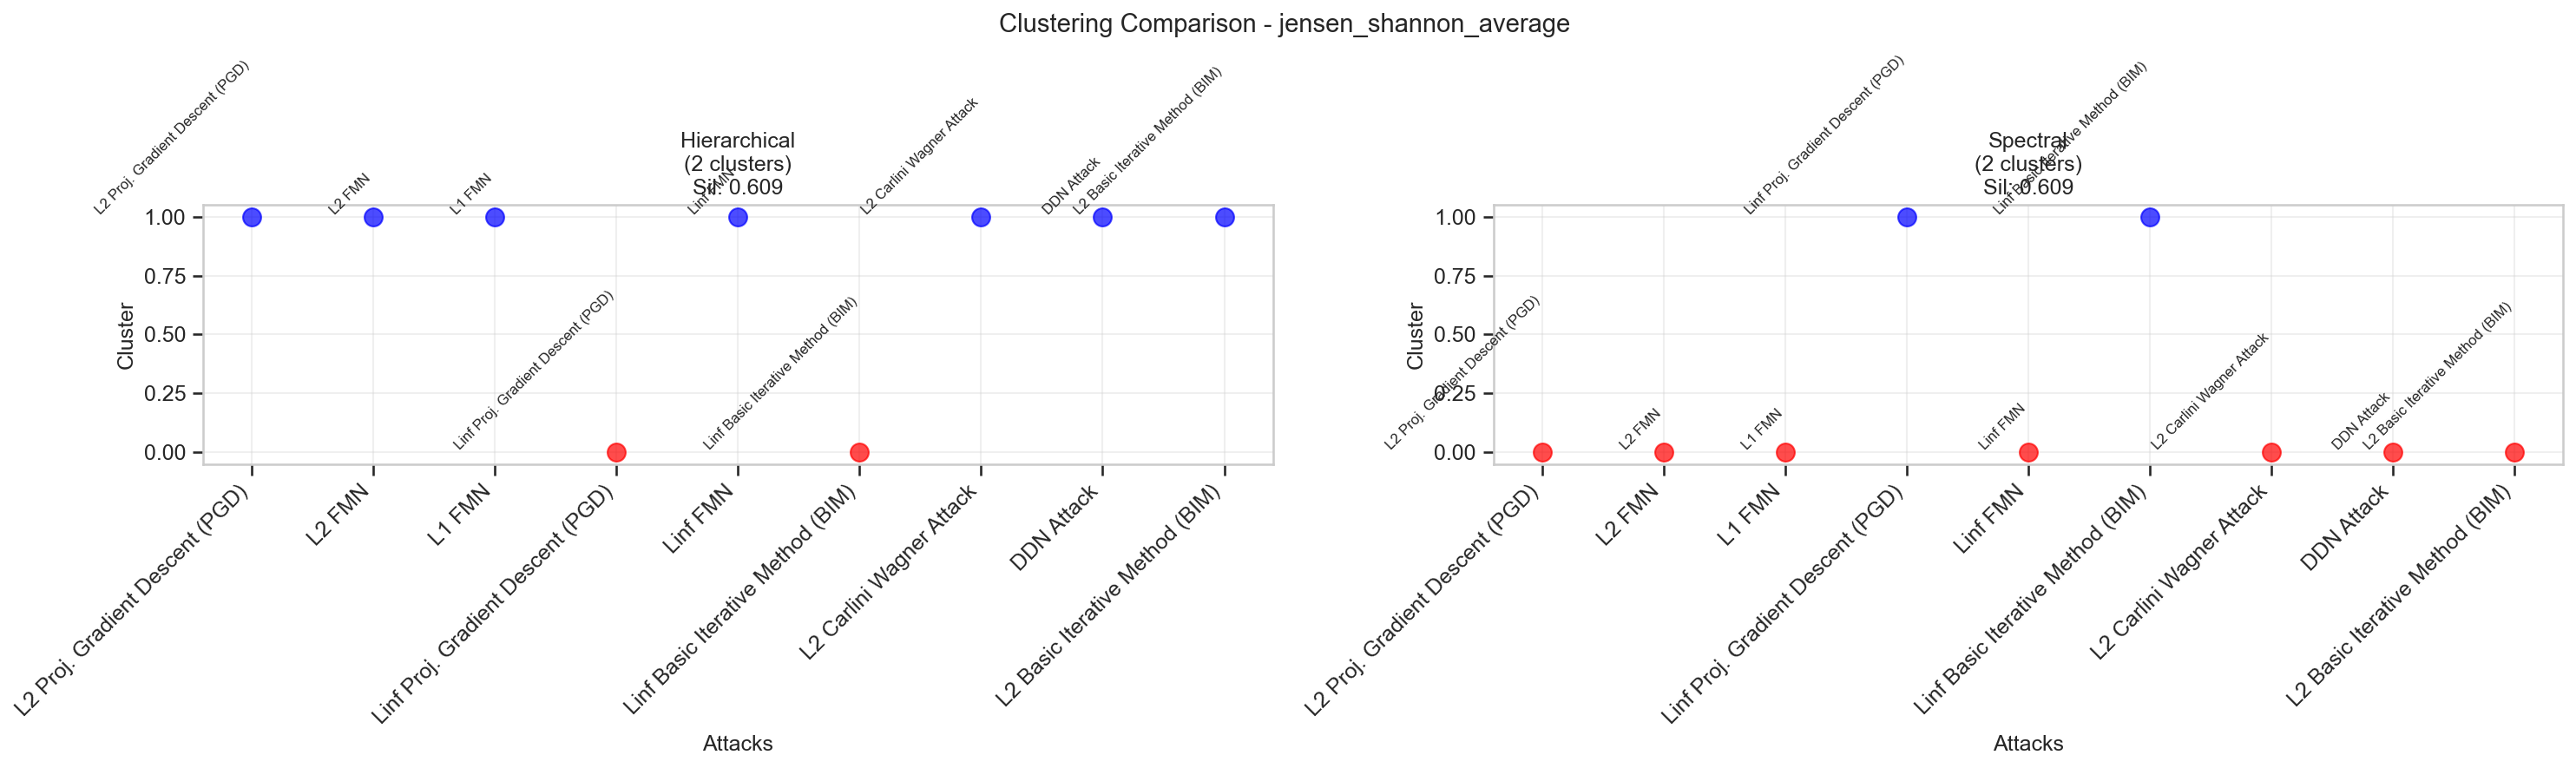

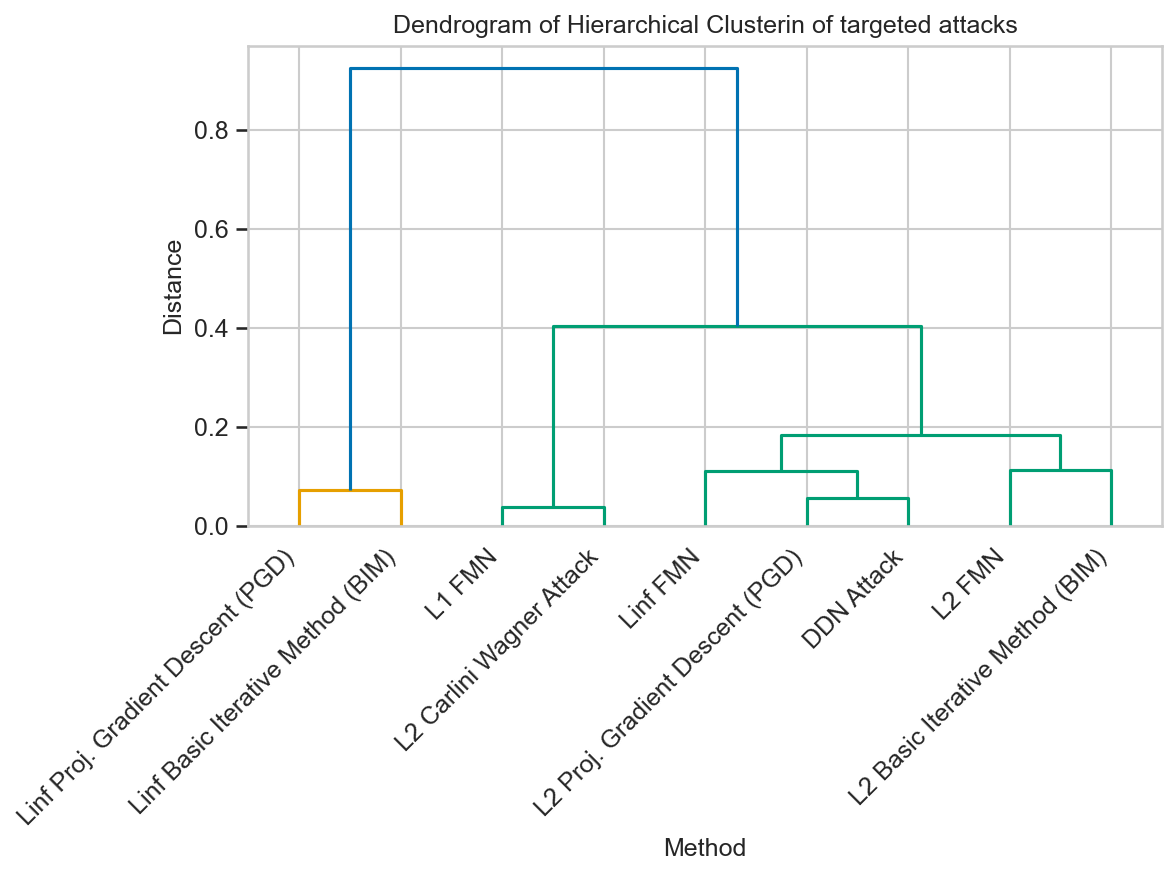

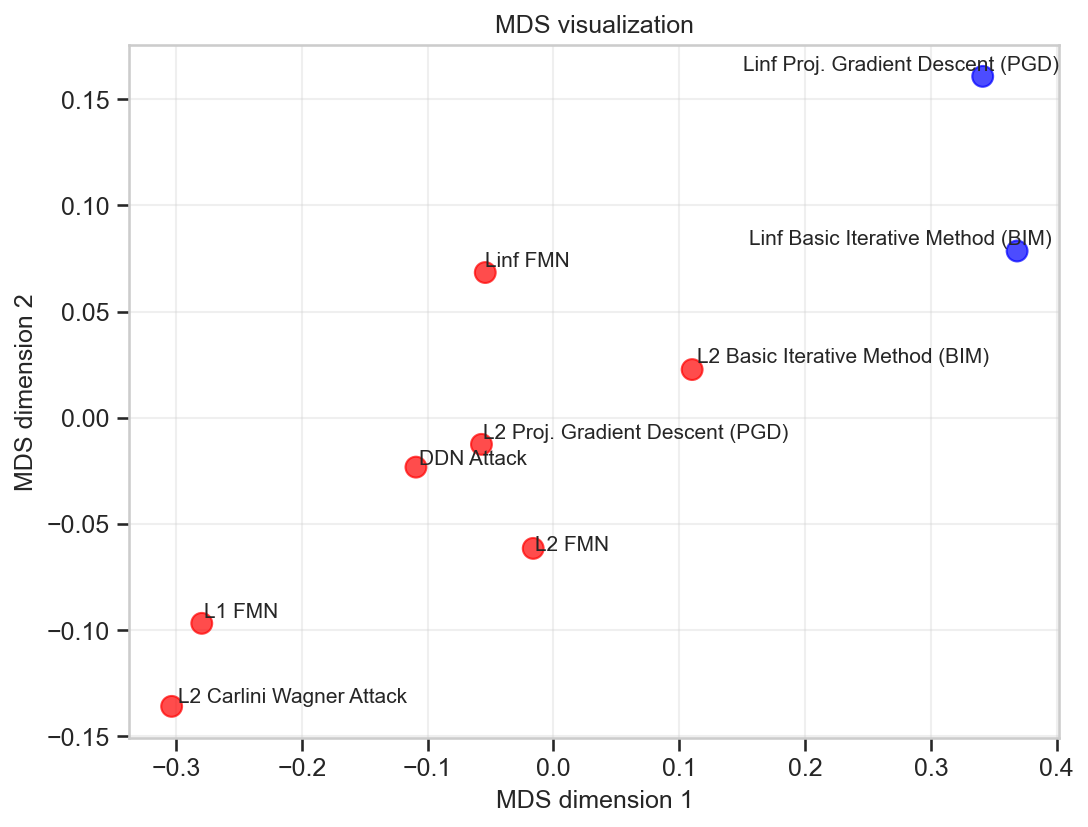


Clustering Summary for jensen_shannon_average:
  hierarchical: 2 clusters (silhouette: 0.609)  spectral: 2 clusters (silhouette: 0.609)

In [27]:
attack_analyzer = AdversarialAttacksAnalysis(attack_df)

attack_analyzer.comprehensive_analysis(['average'])

In [71]:
# add cluster information to dataframe

# map label to attack
attack_to_label = {attack: label for label, attack in zip(attack_analyzer.clustering_results["jensen_shannon_average"]["hierarchical"]["labels"], attack_analyzer.attacks)}
attack_df["cluster_attack"] = attack_df["attack"].map(attack_to_label)


--- Predicting cluster_attack ---
Accuracy: 0.7892063629290222
              precision    recall  f1-score   support

           0       0.58      0.19      0.28     10282
           1       0.81      0.96      0.88     35986

    accuracy                           0.79     46268
   macro avg       0.69      0.57      0.58     46268
weighted avg       0.76      0.79      0.74     46268



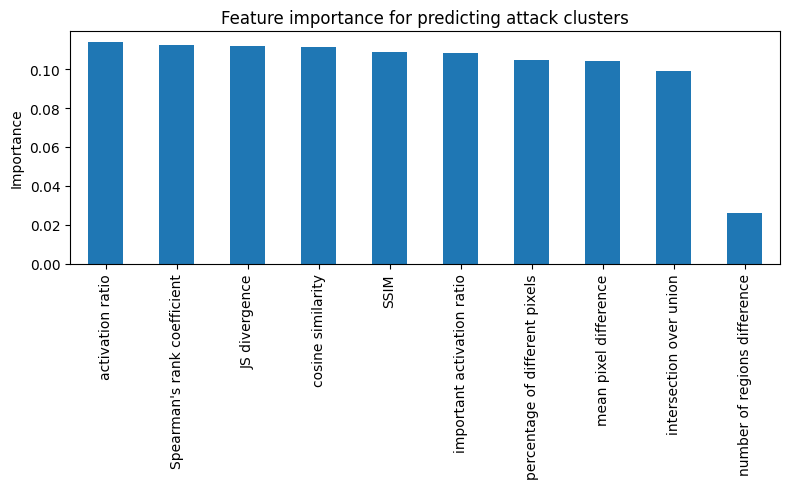

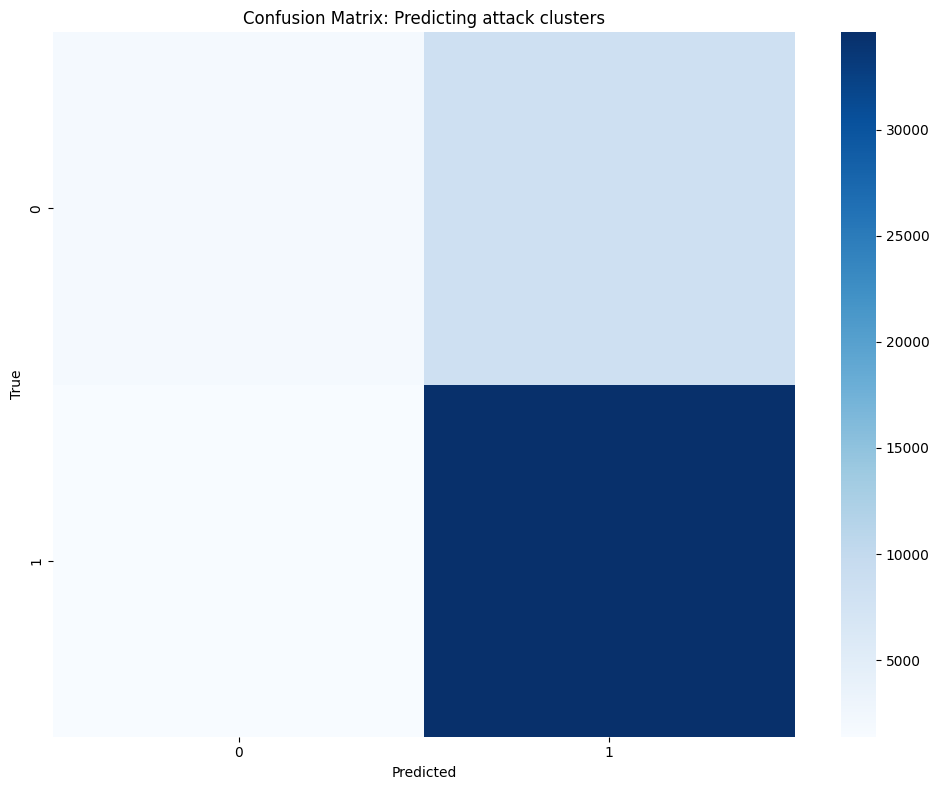

In [72]:
run_rf_classification(attack_df, "cluster_attack", "attack clusters", metric_columns, save_plot=True)


--- Predicting attack ---
Accuracy: 0.5038471513789228
              precision    recall  f1-score   support

           0       0.77      0.29      0.42      5141
           1       0.22      0.54      0.32      5141
           2       0.56      0.26      0.35      5141
           3       0.30      0.65      0.41      5141
           4       0.86      0.52      0.65      5141
           5       1.00      0.80      0.89      5141
           6       0.59      0.72      0.65      5140
           7       0.44      0.06      0.11      5141
           8       0.84      0.70      0.76      5141

    accuracy                           0.50     46268
   macro avg       0.62      0.50      0.51     46268
weighted avg       0.62      0.50      0.51     46268



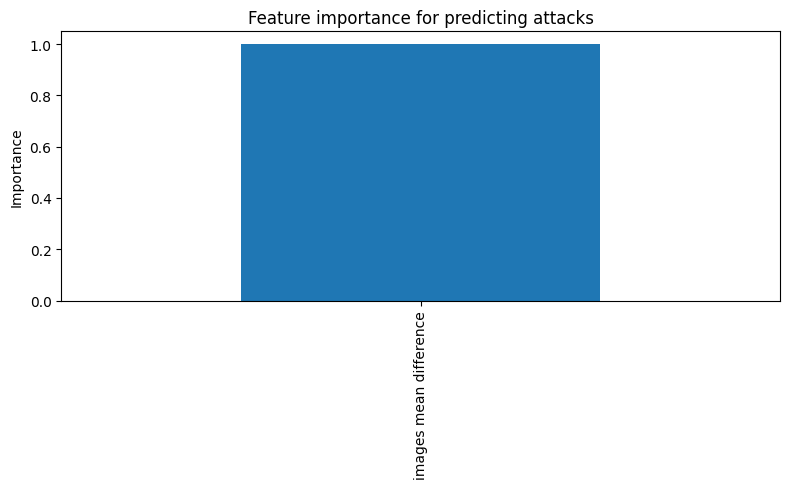

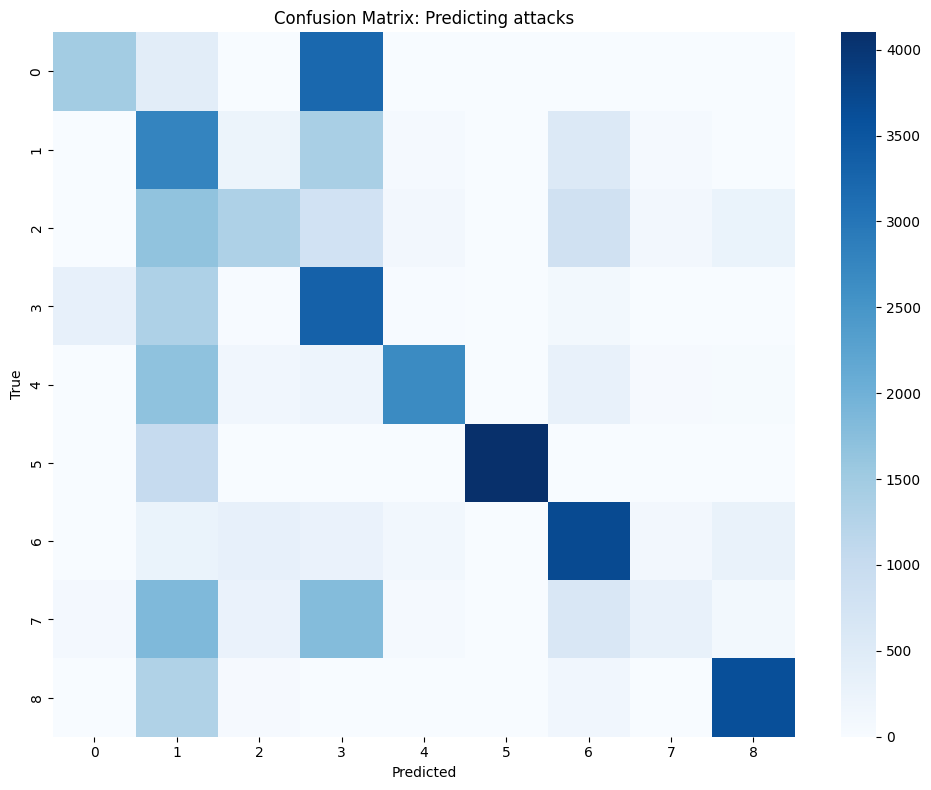

In [73]:
run_rf_classification(attack_df, "attack", "attacks", ["images mean difference"])

# Method-attack interactions

In [28]:
# add integer column indicating the unique attack-method combinations

attack_df["method_attack"] = attack_df["attack"].astype(str) + "_" + attack_df["method"].astype(str)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations
from scipy.special import kl_div
from adjustText import adjust_text
import matplotlib.colors as mcolors

class AttacksMethodsAnalysis:
    def __init__(self, results_df):
        """
        Initialize the analysis with your results dataframe
        """
        self.df = results_df
        self.metric_columns = [
            'mean pixel difference', 'activation ratio',
            'important activation ratio', 'JS divergence',    
            'number of regions difference'
        ] 

        self.attacks_methods = self.df['method_attack'].unique()
        self.distance_matrices_per_metric = {}
        self.combined_distance_matrices = {}
        self.clustering_results = {}
        self.silhouette_scores = {}


    def jensen_shannon_divergence(self, p, q, bins=20):
        """
        Calculate Jensen-Shannon divergence between two distributions
        """
        # Create histograms with same bins
        min_val = min(np.min(p), np.min(q))
        max_val = max(np.max(p), np.max(q))

        if min_val == max_val:
        # Both distributions are constant → they look identical
            return 0.0  
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        hist_p = hist_p + epsilon
        hist_q = hist_q + epsilon
        # Normalize to probabilities
        hist_p = hist_p / np.sum(hist_p)
        hist_q = hist_q / np.sum(hist_q)
        
        # Calculate M = (P + Q) / 2
        m = (hist_p + hist_q) / 2
        
        # KL divergence
        def kl_divergence(x, y):
            return np.sum(x * np.log(x / y))
        
        # JS divergence
        js_div = 0.5 * kl_divergence(hist_p, m) + 0.5 * kl_divergence(hist_q, m)
        return js_div
    
    def calculate_distance_matrices_per_metric(self):
        """
        Calculate distance matrices for each metric separately
        """
        n_attacks = len(self.attacks_methods)
        
        for metric in self.metric_columns:
            print(f"Calculating distances for {metric}...")
            
            # Initialize distance matrices
            js_matrix = np.zeros((n_attacks, n_attacks))

            # Get distributions for each attack
            attack_distributions = {}
            for method_attack in self.attacks_methods:
                attack_data = self.df[self.df['method_attack'] == method_attack][metric].dropna()
                if len(attack_data) == 0:
                    print(f"Warning: No data for method attack {method_attack} and metric {metric}")
                    continue
                attack_distributions[method_attack] = attack_data.values

            # Calculate pairwise distances
            for i, attack1 in enumerate(self.attacks_methods):
                for j, attack2 in enumerate(self.attacks_methods):
                    if i == j:
                        js_matrix[i, j] = 0
                  
                    else:
                        if attack1 in attack_distributions and attack2 in attack_distributions:
                            dist1 = attack_distributions[attack1]
                            dist2 = attack_distributions[attack2]

                            # Jensen-Shannon divergence
                            js_matrix[i, j] = self.jensen_shannon_divergence(dist1, dist2)

              
            self.distance_matrices_per_metric[metric] = {
                'jensen_shannon': js_matrix
            }
        print(np.isnan(js_matrix).sum(), "NaNs in js_matrix")
    
    def combine_distance_matrices(self, combination_method='average'):
        """
        Combine distance matrices across all metrics
        
        combination_method options:
        - 'average': Simple average of distances across metrics
        - 'weighted_average': Weighted by inverse of metric variance
        - 'max': Maximum distance across metrics
        - 'euclidean': Euclidean distance in metric space
        """
        n_attacks = len(self.attacks_methods)
        n_metrics = len(self.metric_columns)

        for distance_type in ['jensen_shannon']:
            if combination_method == 'average':
                # Simple average
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        D = self.distance_matrices_per_metric[metric][distance_type]

                        # Compute robust min/max using percentiles
                        p_low, p_high = np.percentile(D, [0.05, 99.5])
                        print(p_low, p_high, "low and high percentiles")
                        if p_high == p_low:
                            D_norm = np.zeros_like(D)
                        else:
                            D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)
                        #D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)  # clip to [0,1]

                        combined_matrix += D_norm
                        #combined_matrix += self.distance_matrices_per_metric[metric][distance_type]
                combined_matrix /= len(self.metric_columns)
                
            elif combination_method == 'weighted_average':
                # Weighted by inverse variance of each metric
                weights = []
                matrices = []
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        # Calculate weight as inverse of variance
                        variance = np.var(matrix[matrix > 0])
                        weight = 1.0 / (variance + 1e-10)  # Add small epsilon to avoid division by zero
                        weights.append(weight)
                        matrices.append(matrix)
                
                weights = np.array(weights)
                weights = weights / np.sum(weights)  # Normalize weights

                combined_matrix = np.zeros((n_attacks, n_attacks))
                for weight, matrix in zip(weights, matrices):
                    combined_matrix += weight * matrix
                    
            elif combination_method == 'max':
                # Maximum distance across metrics
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        combined_matrix = np.maximum(combined_matrix, matrix)
                        
            elif combination_method == 'euclidean':
                # Euclidean distance in metric space
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for i in range(n_attacks):
                    for j in range(n_attacks):
                        if i != j:
                            distances = []
                            for metric in self.metric_columns:
                                if metric in self.distance_matrices_per_metric:
                                    distances.append(self.distance_matrices_per_metric[metric][distance_type][i, j])
                            combined_matrix[i, j] = np.sqrt(np.sum(np.array(distances)**2))
            
            self.combined_distance_matrices[f"{distance_type}_{combination_method}"] = combined_matrix
            
        print(f"Combined distance matrices using {combination_method} method")
    
    def calculate_silhouette_scores(self, distance_matrix_key, max_clusters=33):
        """
        Calculate silhouette scores for different numbers of clusters
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        silhouette_scores = {}
        
        for n_clusters in range(2, min(len(self.attacks_methods), max_clusters + 1)):
            scores = {}
            
            # Hierarchical clustering
            linkage_matrix = linkage(squareform(distance_matrix), method='ward')
            hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            if len(np.unique(hier_labels)) == n_clusters:  # Check if we got the expected number of clusters
                scores['hierarchical'] = silhouette_score(distance_matrix, hier_labels, metric='precomputed')
            
            # Spectral clustering
            try:
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
                spec_labels = spectral.fit_predict(affinity_matrix)
                if len(np.unique(spec_labels)) == n_clusters:
                    scores['spectral'] = silhouette_score(distance_matrix, spec_labels, metric='precomputed')
            except Exception as e:
                print(f"Spectral clustering failed for {n_clusters} clusters: {e}")
            
            # Agglomerative clustering
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                       metric='precomputed', 
                                                       linkage='average')
                agg_labels = agg_clustering.fit_predict(distance_matrix)
                if len(np.unique(agg_labels)) == n_clusters:
                    scores['agglomerative'] = silhouette_score(distance_matrix, agg_labels, metric='precomputed')
            except Exception as e:
                print(f"Agglomerative clustering failed for {n_clusters} clusters: {e}")
            
            silhouette_scores[n_clusters] = scores
        
        self.silhouette_scores[distance_matrix_key] = silhouette_scores
        return silhouette_scores
    
    
    def perform_clustering_with_optimal_clusters(self, distance_matrix_key, num_clusters=None):
        """
        Perform clustering using optimal number of clusters based on silhouette scores
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        results = {}
        
        # Find optimal clusters for other methods
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        for method in ['hierarchical', 'spectral', 'agglomerative']:
            method_scores = {k: v.get(method, -1) for k, v in silhouette_data.items()}
            if num_clusters is not None:
                optimal_clusters = num_clusters
            else:
                optimal_clusters = max(method_scores, key=method_scores.get)

            print(f"Optimal clusters for {method}: {optimal_clusters} (silhouette score: {method_scores[optimal_clusters]:.3f})")
            
            if method == 'hierarchical':
                linkage_matrix = linkage(squareform(distance_matrix), method='ward')
                labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters],
                    'linkage_matrix': linkage_matrix
                }
            elif method == 'spectral':
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=optimal_clusters, affinity='precomputed', 
                                            random_state=42)
                labels = spectral.fit_predict(affinity_matrix) + 1
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters]
                }
        
        self.clustering_results[distance_matrix_key] = results
        return results
    
    def plot_silhouette_analysis(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot silhouette scores for different numbers of clusters
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        plt.figure(figsize=figsize)

        methods = ['hierarchical', 'spectral']
        colors = ['blue', 'red']
        markers = ['o', 's']

        # Plot both methods on the same plot
        for idx, method in enumerate(methods):
            clusters = []
            scores = []
            for n_clusters, method_scores in silhouette_data.items():
                if method in method_scores:
                    clusters.append(n_clusters)
                    scores.append(method_scores[method])
            
            if clusters:
                plt.plot(clusters, scores, marker=markers[idx], color=colors[idx], 
                        linewidth=2, markersize=8, label=f'{method.title()} Clustering')

        plt.title(f'Silhouette score comparison')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/targeted/silhouette_analysis_{distance_matrix_key}_methods_attacks_targeted.svg")
        plt.show()
    
    def plot_combined_distance_heatmap(self, distance_matrix_key, figsize=(10, 8)):
        """
        Plot heatmap of combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        plt.figure(figsize=figsize)
        sns.heatmap(distance_matrix, 
                   xticklabels=self.attacks_methods, yticklabels=self.attacks_methods,
                   annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Combined distance matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    

    def visualize_cluster_grid(self, clustering_key, algorithm="hierarchical", figsize=(8, 6)):
        """
        Visualize the clustering results as a grid:
        - rows = attacks
        - columns = methods
        - each cell = cluster assignment (number + colour)
        """
        if clustering_key not in self.clustering_results:
            raise ValueError(f"No clustering results found for {clustering_key}")

        labels = self.clustering_results[clustering_key][algorithm]["labels"]

        # Get unique method_attack combos
        unique_combos = self.df["method_attack"].unique()
        if len(unique_combos) != len(labels):
            raise ValueError(
                f"Number of labels ({len(labels)}) does not match number of unique method_attack combos ({len(unique_combos)})"
            )

        # Build mapping DataFrame
        cluster_df = pd.DataFrame({
            "method_attack": unique_combos,
            "cluster": labels
        })
        cluster_df[["attack", "method"]] = cluster_df["method_attack"].str.split("_", n=1, expand=True)
        # Define desired order  
        attack_order = [
             "L2 Carlini Wagner Attack", 
            "Linf FMN", "L1 FMN", "L2 FMN", "DDN Attack", 
            "Linf Basic Iterative Method (BIM)", "L2 Basic Iterative Method (BIM)",  "Linf Proj. Gradient Descent (PGD)", "L2 Proj. Gradient Descent (PGD)",
        ]

        method_order = [
            "GradCAM", "AblationCAM", "ScoreCAM", "GradCAM++", "LayerCAM", 
            "EigenCAM", "KPCA-CAM", "EigenGradCAM", "FullGrad"]

        # Convert columns to ordered categoricals
        cluster_df["attack"] = pd.Categorical(cluster_df["attack"], categories=attack_order, ordered=True)
        cluster_df["method"] = pd.Categorical(cluster_df["method"], categories=method_order, ordered=True)
        # Pivot: attacks x methods
        pivot = cluster_df.pivot(index='attack', columns='method', values='cluster')

        # Determine number of clusters present in your pivot
        n_clusters = cluster_df["cluster"].nunique()

        # Use the same colormap (Accent) with discrete bins
        cmap = plt.colormaps["Accent"].resampled(n_clusters)
        cmap = mcolors.ListedColormap([cmap(i) for i in range(n_clusters)])

        # Plot
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
        pivot,
        annot=True, fmt="d",
        cmap=cmap,
        cbar=False,        # no continuous bar (clusters are categorical)
        linewidths=0.5,
        linecolor="lightgrey"
        )
        ax.set_title("Cluster assignments per attack/method")
        ax.set_xlabel("Method")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylabel("Attack")
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/targeted/clustering_methods_attacks_targeted.svg")
        plt.show()


    def plot_dendrogram(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot dendrogram for hierarchical clustering
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        plt.figure(figsize=figsize)
        linkage_matrix = self.clustering_results[distance_matrix_key]['hierarchical']['linkage_matrix']
        
        dendrogram(linkage_matrix, labels=self.attacks_methods, leaf_rotation=90, leaf_font_size=12)
        plt.title(f'Dendrogram of Hierarchical Clustering of targeted attack/method combinations')
        plt.ylabel('Distance')
        plt.xlabel('Method')
        plt.tight_layout()
        plt.show()
    
    def mds_visualization(self, distance_matrix_key, figsize=(8, 6)):
        """
        Visualize methods using MDS based on combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        # Perform MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(distance_matrix)
        
        # Use spectral clustering results
        if distance_matrix_key in self.clustering_results:
            labels = self.clustering_results[distance_matrix_key]['spectral']['labels']
        else:
            labels = np.zeros(coords.shape[0], dtype=int)  # fallback if no clustering

        n_clusters = len(np.unique(labels))
        cmap = plt.colormaps["Accent"].resampled(n_clusters)
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            coords[:, 0],
            coords[:, 1],
            s=100,
            alpha=0.7,
            c=labels,          # cluster IDs directly
            cmap=cmap
        )

        plt.title(f'MDS visualization')
        plt.xlabel('MDS dimension 1')
        plt.ylabel('MDS dimension 2')
        plt.grid(True, alpha=0.3)

        plt.savefig(f"results/big_dataset/targeted/mds_methods_attacks_targeted.svg")
        plt.show()
    
    def comprehensive_analysis(self, combination_methods=['average', 'weighted_average']):
        """
        Run comprehensive analysis with all combination methods
        """
        print("=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===\n")
        
        # Calculate distance matrices per metric
        self.calculate_distance_matrices_per_metric()
        
        # Try different combination methods
        for comb_method in combination_methods:
            print(f"\n{'='*60}")
            print(f"ANALYSIS WITH {comb_method.upper()} COMBINATION METHOD")
            print('='*60)
            
            # Combine matrices
            self.combine_distance_matrices(comb_method)
            
            # Analyze both distance types
            for distance_type in ['jensen_shannon']:
                matrix_key = f"{distance_type}_{comb_method}"
                
                print(f"\n--- {distance_type.title()} Distance ---")
                
                
                # Calculate silhouette scores
                self.calculate_silhouette_scores(matrix_key)
                
                # Plot silhouette analysis
                self.plot_silhouette_analysis(matrix_key)
                
                # Perform clustering with optimal number of clusters
                results = self.perform_clustering_with_optimal_clusters(matrix_key)
                

                self.mds_visualization(matrix_key)
                self.visualize_cluster_grid(matrix_key)
                # Print summary
                print(f"\nClustering Summary for {matrix_key}:")
                for method, result in results.items():
                    print(f"  {method}: {result['n_clusters']} clusters", end="")
                    if 'silhouette_score' in result:
                        print(f" (silhouette: {result['silhouette_score']:.3f})", end="")

    def summary_report(self):
        """
        Generate a summary report
        """
        print("=== ADVERSARIAL ATTACK ANALYSIS SUMMARY ===\n")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Number of attacks_methods: {len(self.attacks_methods)}")
        print(f"Attacks: {', '.join(self.attacks_methods)}")
        print(f"Number of images: {len(self.df['image ID'].unique())}")
        print(f"Metrics analyzed: {len(self.metric_columns)}")
        
        print("\n=== BASIC STATISTICS ===")
        for metric in self.metric_columns:
            print(f"\n{metric}:")
            stats_df = self.df.groupby('method')[metric].agg(['count', 'mean', 'std', 'median']).round(4)
            print(stats_df)

=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===

Calculating distances for mean pixel difference...
Calculating distances for activation ratio...
Calculating distances for important activation ratio...
Calculating distances for JS divergence...
Calculating distances for number of regions difference...
0 NaNs in js_matrix

ANALYSIS WITH AVERAGE COMBINATION METHOD
0.0 0.18076666950035664 low and high percentiles
0.0 0.6282454096387701 low and high percentiles
0.0 0.061708443735998375 low and high percentiles
0.0 0.5382178663249015 low and high percentiles
0.0 0.2121322745765361 low and high percentiles
Combined distance matrices using average method

--- Jensen_Shannon Distance ---


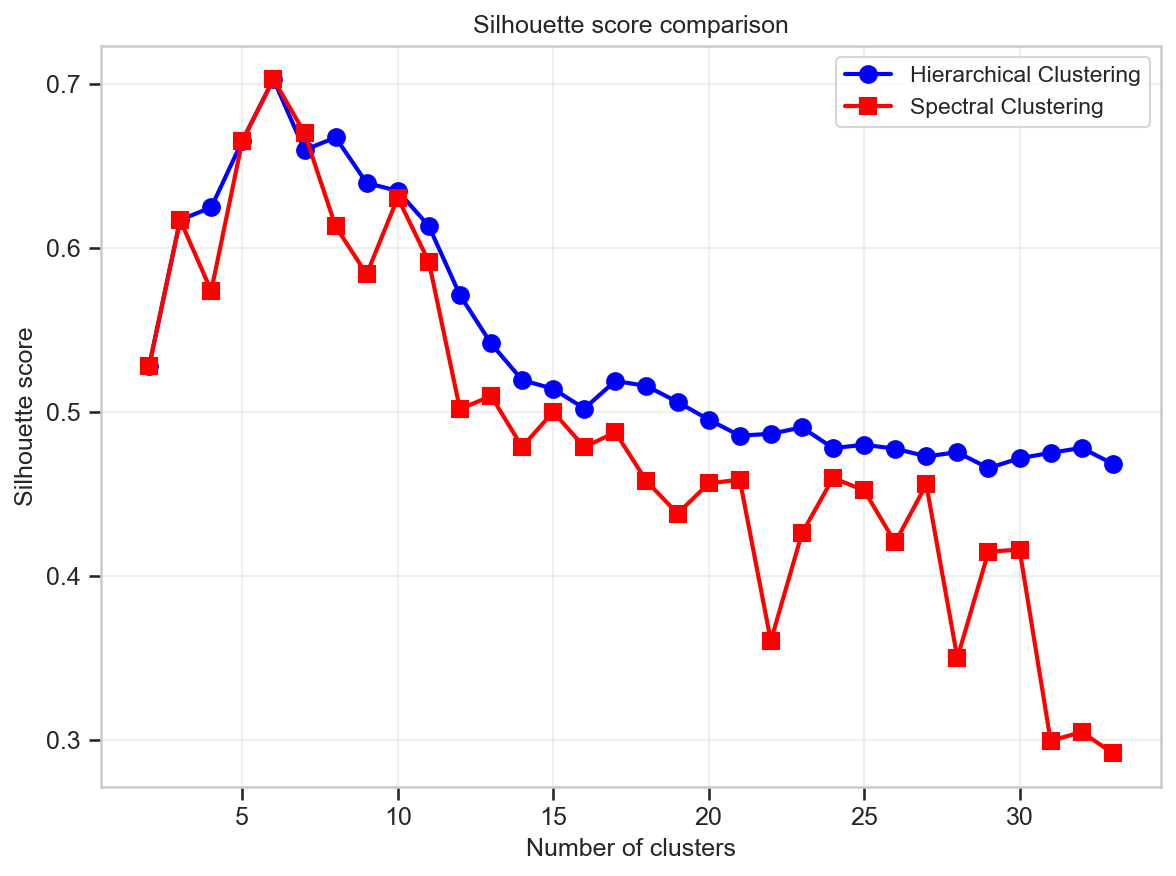

Optimal clusters for hierarchical: 6 (silhouette score: 0.703)
Optimal clusters for spectral: 6 (silhouette score: 0.703)
Optimal clusters for agglomerative: 6 (silhouette score: 0.703)


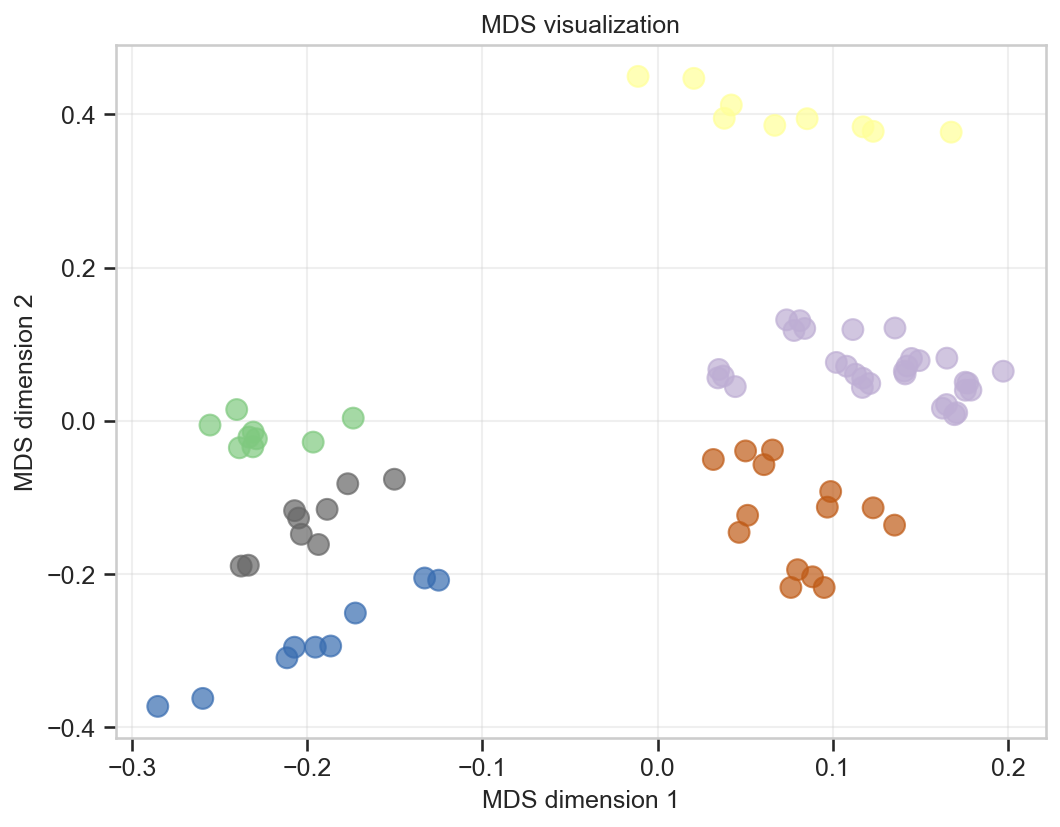

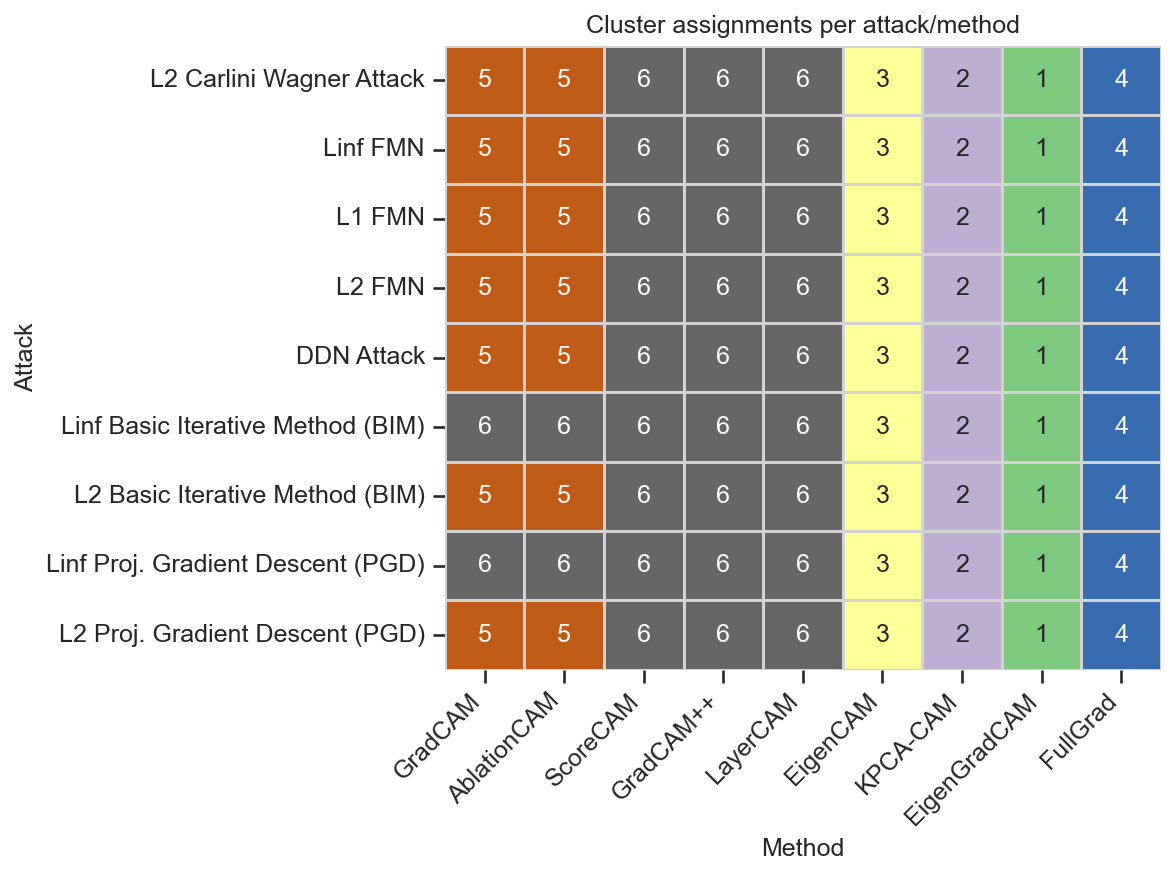


Clustering Summary for jensen_shannon_average:
  hierarchical: 6 clusters (silhouette: 0.703)  spectral: 6 clusters (silhouette: 0.703)

In [30]:
method_attack_analyzer = AttacksMethodsAnalysis(attack_df)
method_attack_analyzer.comprehensive_analysis(['average'])


--- Predicting method_attack ---
Accuracy: 0.06931111111111112
              precision    recall  f1-score   support

           0       0.06      0.05      0.06       557
           1       0.05      0.04      0.05       556
           2       0.05      0.05      0.05       558
           3       0.08      0.08      0.08       558
           4       0.08      0.09      0.09       552
           5       0.02      0.02      0.02       552
           6       0.06      0.07      0.07       556
           7       0.03      0.03      0.03       554
           8       0.05      0.05      0.05       559
           9       0.06      0.06      0.06       552
          10       0.06      0.05      0.06       552
          11       0.07      0.08      0.07       555
          12       0.12      0.15      0.13       556
          13       0.08      0.10      0.09       556
          14       0.04      0.04      0.04       560
          15       0.08      0.10      0.09       557
          16     

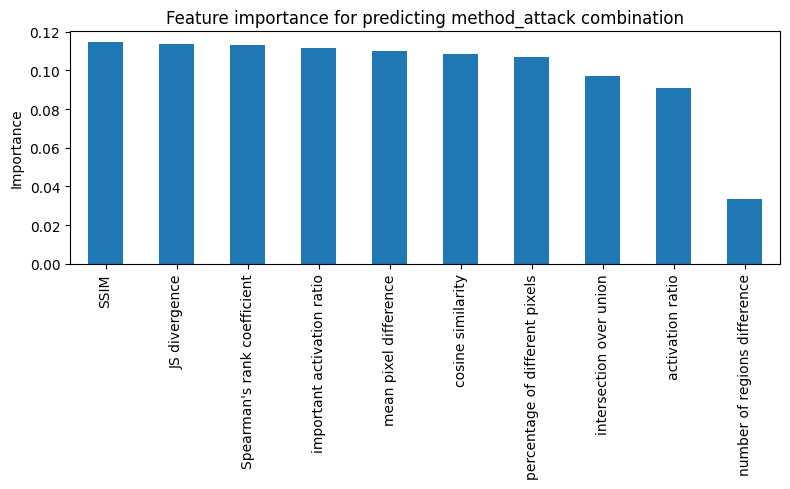

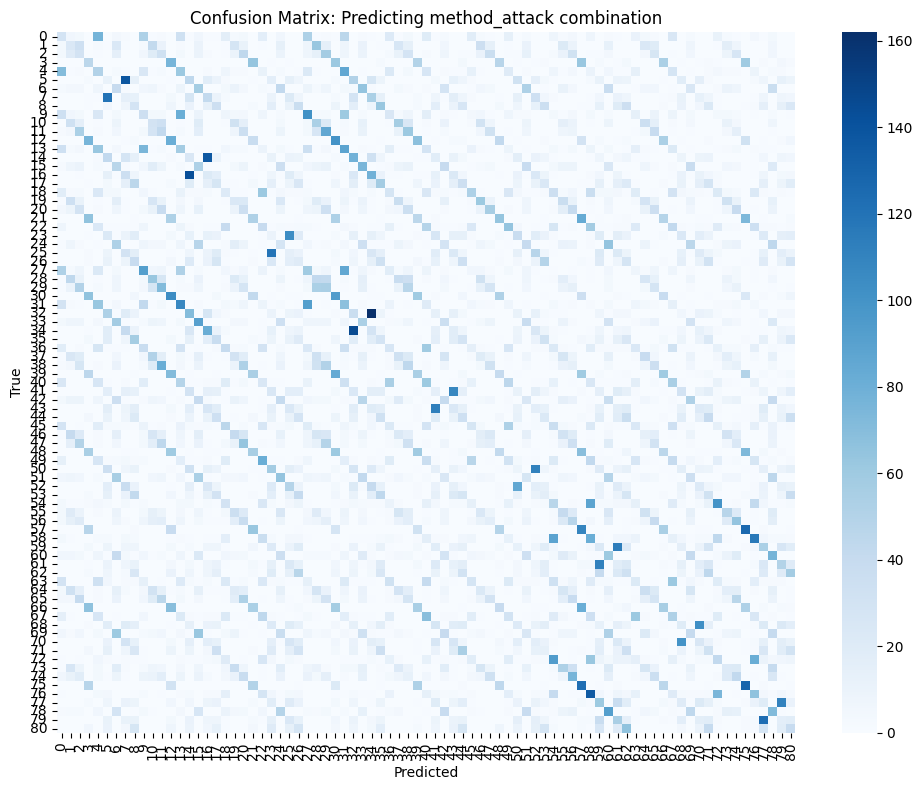

In [78]:
# randomly subsample before doing rf classifier

sampled_df = attack_df.sample(n=150000, random_state=2)
run_rf_classification(sampled_df, "method_attack", "method_attack combination", metric_columns)

# RF on clustering results

In [79]:
attack_method_to_label = {method_attack: label for label, method_attack in zip(method_attack_analyzer.clustering_results["jensen_shannon_average"]["hierarchical"]["labels"], 
                                                                 method_attack_analyzer.attacks_methods)}

attack_df["cluster_attack_method"] = attack_df["method_attack"].map(attack_method_to_label)


--- Predicting cluster_attack_method ---
Accuracy: 0.7987377885363535
              precision    recall  f1-score   support

           0       0.60      0.61      0.61      5141
           1       0.66      0.72      0.69      5141
           2       0.62      0.48      0.54      5141
           3       0.94      0.93      0.93      5141
           4       0.77      0.80      0.78      7997
           5       0.91      0.93      0.92     17707

    accuracy                           0.80     46268
   macro avg       0.75      0.74      0.75     46268
weighted avg       0.80      0.80      0.80     46268



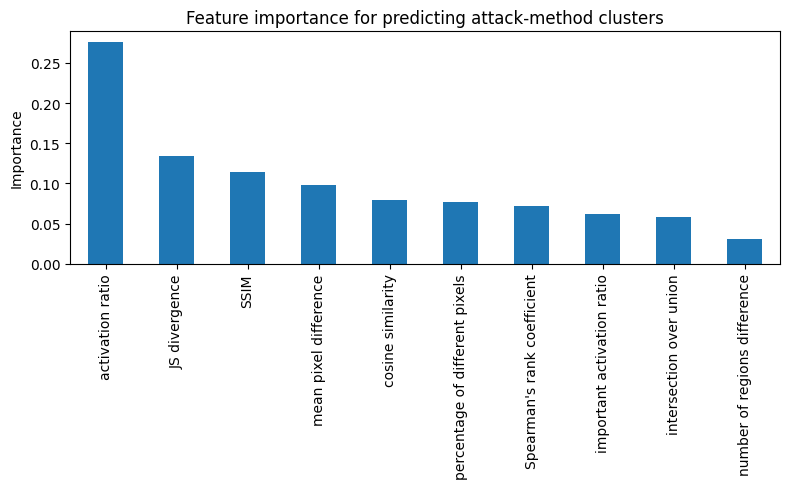

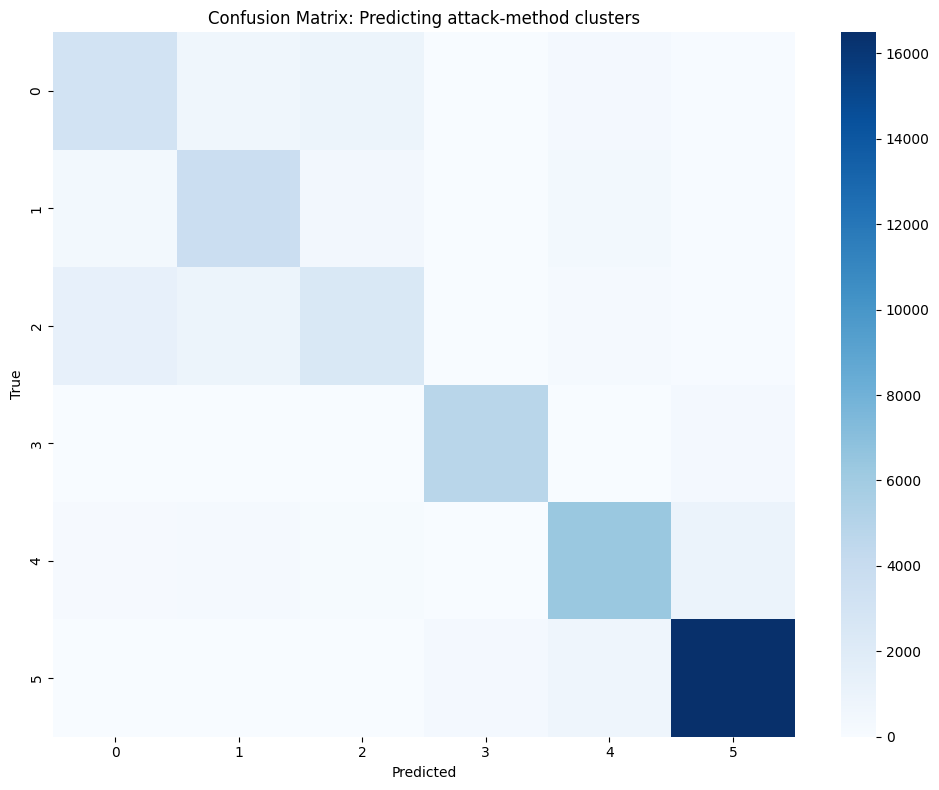

In [80]:
run_rf_classification(attack_df, "cluster_attack_method", "attack-method clusters", metric_columns)

In [40]:
attack_df

image ID    method                           attack        true class  \
0              0   GradCAM  L2 Proj. Gradient Descent (PGD)             tench   
1              2   GradCAM  L2 Proj. Gradient Descent (PGD)             tench   
2              3   GradCAM  L2 Proj. Gradient Descent (PGD)          goldfish   
3              4   GradCAM  L2 Proj. Gradient Descent (PGD)          goldfish   
4              5   GradCAM  L2 Proj. Gradient Descent (PGD)          goldfish   
...          ...       ...                              ...               ...   
188382      2989  ScoreCAM  L2 Basic Iterative Method (BIM)  hen-of-the-woods   
188384      2994  ScoreCAM  L2 Basic Iterative Method (BIM)               ear   
188385      2995  ScoreCAM  L2 Basic Iterative Method (BIM)               ear   
188386      2997  ScoreCAM  L2 Basic Iterative Method (BIM)     toilet tissue   
188387      2999  ScoreCAM  L2 Basic Iterative Method (BIM)     toilet tissue   

           predicted class  images mean difference  original score  \
0               solar dish                0.000664        0.539809   
1                 sombrero                0.000386        0.565740   
2       American chameleon                0.000055        0.279217   
3              grasshopper                0.000055        0.342394   
4              barn spider                0.000183        0.414257   
...                    ...                     ...             ...   
188382             burrito                0.000215        0.314443   
188384         pomegranate                0.000039        0.425354   
188385            crayfish                0.000281        0.277503   
188386  cellular telephone                0.000038        0.311979   
188387          wall clock                0.000087        0.871726   

        adversarial score  mean pixel difference  \
0                0.124351               0.222886   
1                0.635017               0.215067   
2                0.200578               0.205285   
3                0.173491               0.244639   
4                0.659785               0.217485   
...                   ...                    ...   
188382           0.089837               0.460103   
188384           0.136800               0.202876   
188385           0.130514               0.206423   
188386           0.057700               0.183075   
188387           0.191386               0.260508   

        percentage of different pixels  ...  JS divergence  \
0                             0.435348  ...       0.565675   
1                             0.386779  ...       0.321693   
2                             0.331792  ...       0.265442   
3                             0.470484  ...       0.309065   
4                             0.436882  ...       0.372201   
...                                ...  ...            ...   
188382                        0.776965  ...       0.577651   
188384                        0.380461  ...       0.226577   
188385                        0.374581  ...       0.156125   
188386                        0.344408  ...       0.151014   
188387                        0.503009  ...       0.230605   

        important activation ratio  intersection over union      SSIM  \
0                         0.582218                 0.000698  0.179789   
1                         0.222324                 0.200574  0.332723   
2                         0.138567                 0.089163  0.302233   
3                         0.441416                 0.235689  0.259282   
4                         3.709770                 0.111234  0.307784   
...                            ...                      ...       ...   
188382                    0.113912                 0.004002  0.042311   
188384                    0.567117                 0.161436  0.391217   
188385                    0.137783                 0.259808  0.447356   
188386                    0.727422                 0.101537  0.406119   
188387               

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for t

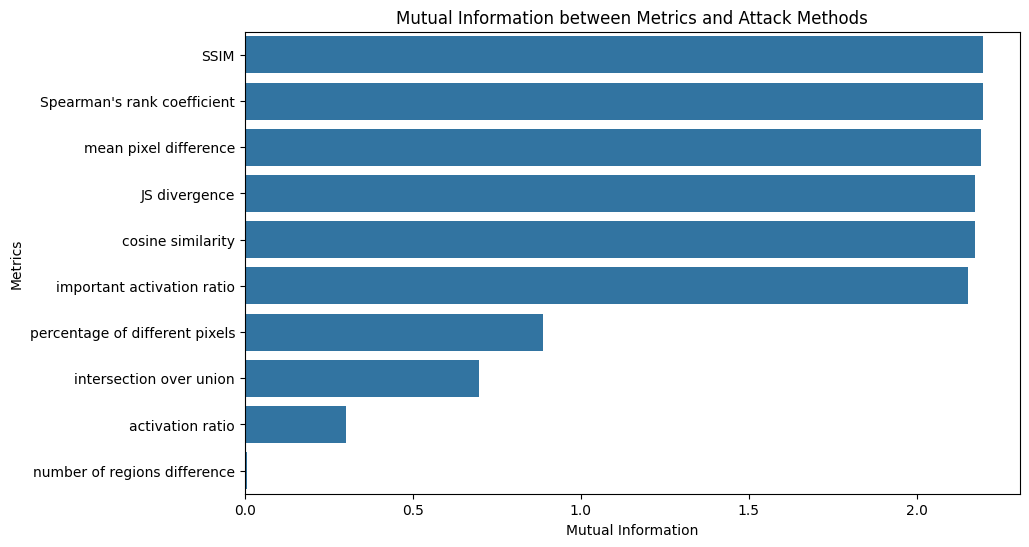

In [42]:
# check mutual information between metrics and methods

from sklearn.feature_selection import mutual_info_classif

X = attack_df[metric_columns].fillna(0)  # Fill NaNs with 0 or use another strategy
y = attack_df['attack']

# Calculate mutual information
mi = mutual_info_classif(X, y, discrete_features=True)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame(mi, index=metric_columns, columns=['mutual_info'])
mi_df = mi_df.sort_values(by='mutual_info', ascending=False)

# Plot mutual information
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_df['mutual_info'], y=mi_df.index)
plt.title('Mutual Information between Metrics and Attack Methods')
plt.xlabel('Mutual Information')
plt.ylabel('Metrics')
plt.show()